
# Predicción de Series de Tiempo de ventas de licor en cadena de supermercados

## Proyecto final- Redes Neuronales

### Nicolás Echeverri Rojas

### 17/04/2022





### Resultados:

El mejor modelo creado  para la predicción de series de tiempo de ventas promedio de licor en la cadena de supermercados tratada es una red neuronal LSTM de 40 capas unida a una capa densa de 30 neuronas, usando el optimizador RMSprop con learning rate de 0.0001, funciones de activación ReLu y alimentada con los datos de las tres semanas anteriores a la predicción.

Se encuentran buenos resultados en las predicciones realizadas en los datos de test tanto cualitativa como cuantitativamente.

## Intrucciones:

Posiblemente correr todo el código sea computacionalmente muy costoso, de tal manera que si se quiere observar los mejores resultados, remitirse a la parte final del notebook.

## Comentarios:
Se lograron buenos resultados a pesar de la estocasticidad de los datos, se espera tener mayor poder computacional para poder seguir buscando de mejora manera los mejores hiperparámetros del modelo.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

plt.rcParams["figure.figsize"] = (14,6)
pd.set_option('display.max_columns', None)

## 1. Cargando datos

In [2]:
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/MyDrive/Proyecto redes neuronales/"

Mounted at /content/drive


In [3]:
df=pd.read_csv(path+"train.csv")
oil=pd.read_csv(path+"oil.csv")
stores=pd.read_csv(path+"stores.csv")

Se poseen tres datasets:

El primero, train.csv es el dataset que posee la información de las ventas de los productos del supermercado. 

El segundo; oil.csv posee el precio del petroleo para una cierta fecha. 

El tercero, stores.csv posee información adicional de la tienda en la que se vendió el producto.

In [4]:
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


Se observa que se tiene alrededor de 3 millones de datos de ventas.

El formato de los datos es el correcto, sólo se debe de cambiat 'date' a tipo datetime

In [6]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [7]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


En el dataset de precio de petroleo se encuentra que el formato de los datos es el correcto, sin embargo, hay datos nulos, de tal manera que se deberá hacer una imputación más adelante de estos.

In [8]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [9]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


### 1.1 Merging the datasets

In [10]:
df=pd.merge (df,stores, how='left', on='store_nbr')

In [11]:
df.tail()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0,Quito,Pichincha,B,6


## 2. EDA

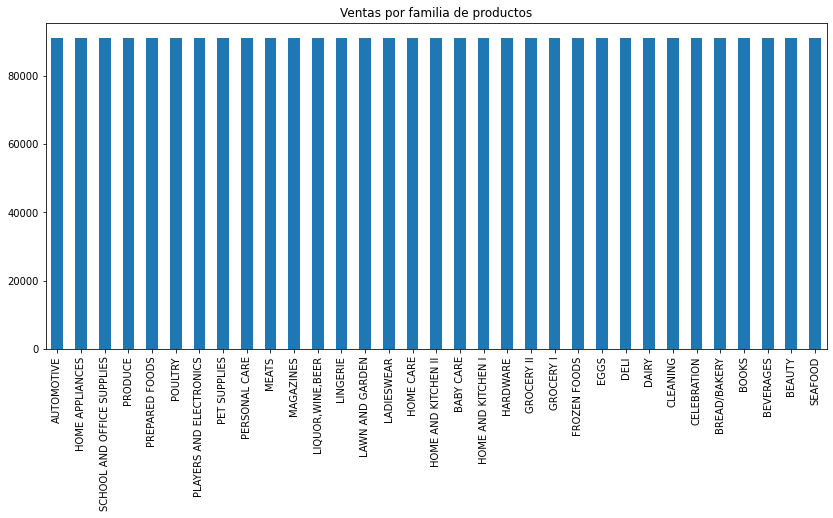

In [12]:
plt.figure(figsize=(14,6))
df['family'].value_counts().plot(kind='bar', title='Ventas por familia de productos')

Se observa que todas las familias de productos poseen igual cantidad de datos, de tal manera que los datos no están desbalanceados

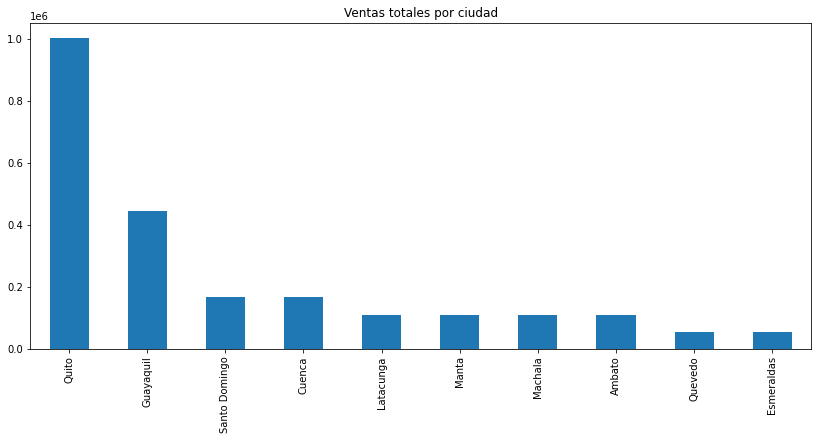

In [13]:
plt.figure(figsize=(14,6))
df['city'].value_counts().head(10).plot(kind='bar', title='Ventas totales por ciudad')

Quito, al ser la capital, es donde se realiza la mayor cantidad de ventas de alimentos

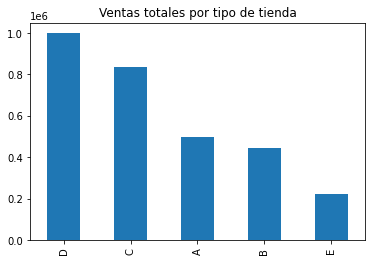

In [14]:
df['type'].value_counts().plot(kind='bar', title='Ventas totales por tipo de tienda')

Se observa que las tiendas tipo D son las que más vendes mientras que las tiendas tipo E son las que menos venden

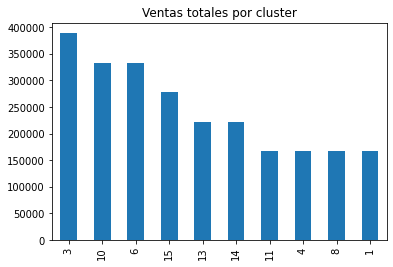

In [15]:
df['cluster'].value_counts().head(10).plot(kind='bar', title='Ventas totales por cluster')

In [16]:
df['family'].value_counts()

AUTOMOTIVE                    90936
HOME APPLIANCES               90936
SCHOOL AND OFFICE SUPPLIES    90936
PRODUCE                       90936
PREPARED FOODS                90936
POULTRY                       90936
PLAYERS AND ELECTRONICS       90936
PET SUPPLIES                  90936
PERSONAL CARE                 90936
MEATS                         90936
MAGAZINES                     90936
LIQUOR,WINE,BEER              90936
LINGERIE                      90936
LAWN AND GARDEN               90936
LADIESWEAR                    90936
HOME CARE                     90936
HOME AND KITCHEN II           90936
BABY CARE                     90936
HOME AND KITCHEN I            90936
HARDWARE                      90936
GROCERY II                    90936
GROCERY I                     90936
FROZEN FOODS                  90936
EGGS                          90936
DELI                          90936
DAIRY                         90936
CLEANING                      90936
CELEBRATION                 

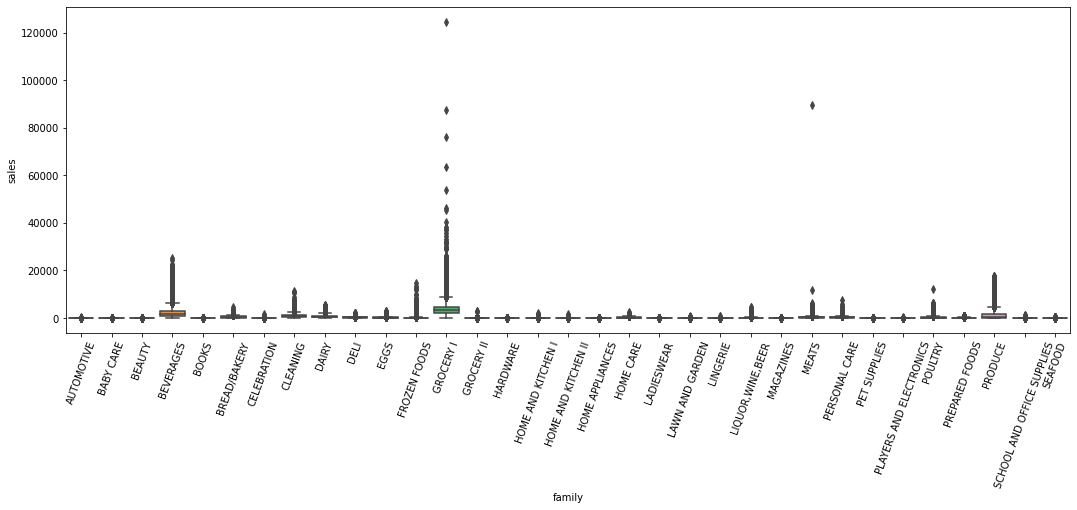

In [17]:
plt.figure(figsize=(18,6))
chart=sns.boxplot(x='family',y='sales',data=df)
chart.set_xticklabels(chart.get_xticklabels(), rotation=70);

Se observa que existen ventas muy por encima del los datos típicos, por ejemplo en grocery I existen ventas de alrededor de 120.000 pesos ecuatorianos

(-20.0, 4000.0)

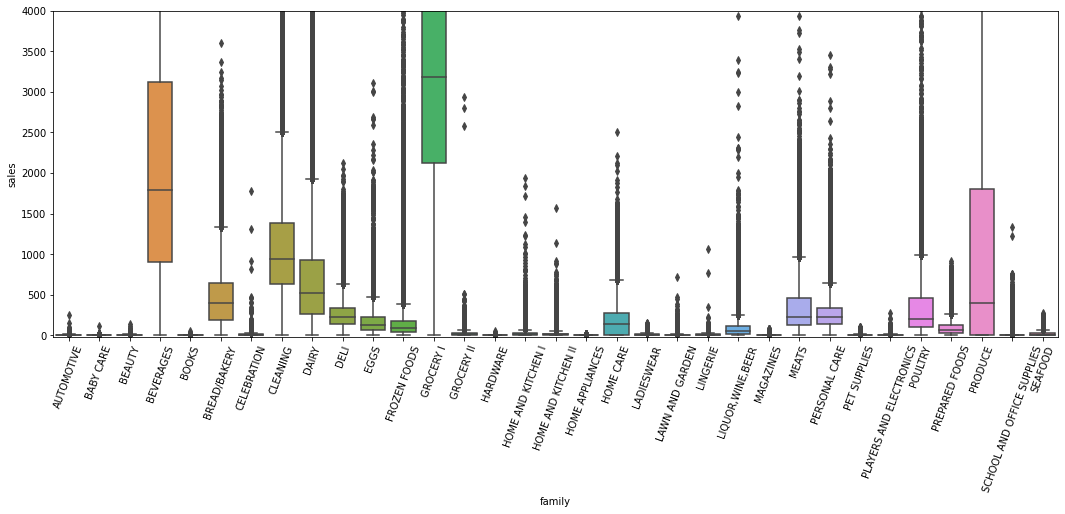

In [18]:
plt.figure(figsize=(18,6))
chart=sns.boxplot(x='family',y='sales',data=df)
chart.set_xticklabels(chart.get_xticklabels(), rotation=70);
plt.ylim(-20,4000)

Realizando un zoom se observa que la mayor cantidad de ventas se da en la categoria Grocery I, luego le sigue bebidas  (Beverages) y productos (Produce)

### Nos vamos a centrar en el análisis de las ventas de licor, vino, cerveza 

In [19]:
dfLiquor=df[df['family']=='LIQUOR,WINE,BEER']

In [20]:
dfLiquor.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
city           0
state          0
type           0
cluster        0
dtype: int64

Se observa que no existen datos nulos en la muestra de datos escogida

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


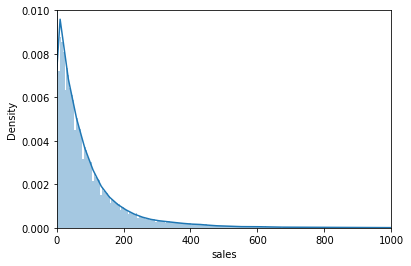

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


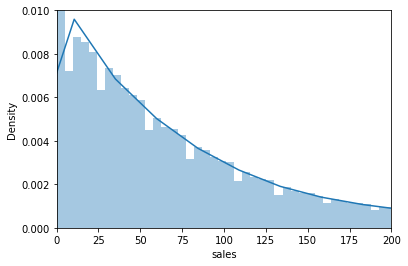

In [21]:
#plt.figure(figsize=(14,6))
sns.distplot(dfLiquor['sales'], bins=1000)
plt.ylim(0,0.01)
plt.xlim(0,1000)
plt.show()
plt.close()

sns.distplot(dfLiquor['sales'], bins=1000)
plt.ylim(0,0.01)
plt.xlim(0,200)
plt.show()
plt.close()

Se observa que la distribución de precios es altamente asimétrica, con asimetría negativa muy marcada.

In [22]:
dfLiquor.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
22,22,2013-01-01,1,"LIQUOR,WINE,BEER",0.0,0,Quito,Pichincha,D,13
55,55,2013-01-01,10,"LIQUOR,WINE,BEER",0.0,0,Quito,Pichincha,C,15
88,88,2013-01-01,11,"LIQUOR,WINE,BEER",0.0,0,Cayambe,Pichincha,B,6
121,121,2013-01-01,12,"LIQUOR,WINE,BEER",0.0,0,Latacunga,Cotopaxi,C,15
154,154,2013-01-01,13,"LIQUOR,WINE,BEER",0.0,0,Latacunga,Cotopaxi,C,15


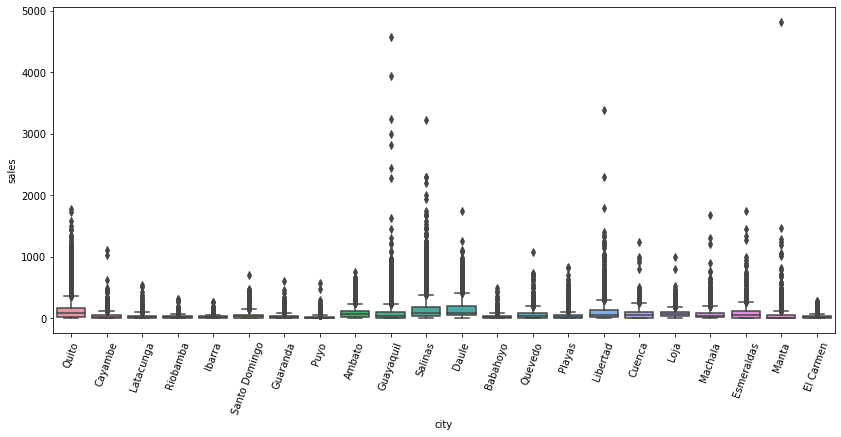

In [23]:
plt.figure(figsize=(14,6))
chart=sns.boxplot(x='city',y='sales',data=dfLiquor)
chart.set_xticklabels(chart.get_xticklabels(), rotation=70);

Se observa que existen fechas sin importar la ciudad en donde las ventas de licor suben mucho, esta es la razón de los outliers


(-20.0, 400.0)

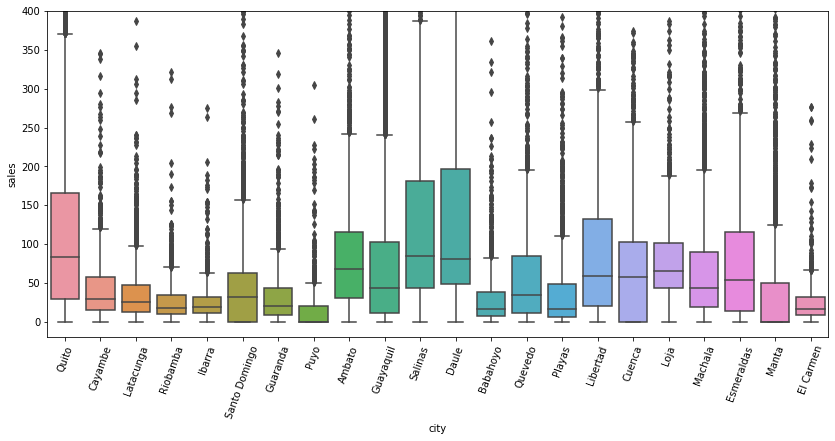

In [24]:
plt.figure(figsize=(14,6))
chart=sns.boxplot(x='city',y='sales',data=dfLiquor)
chart.set_xticklabels(chart.get_xticklabels(), rotation=70);
plt.ylim(-20,400)

Al realizar un zoom se puede analizar de mejor manera las distribuciones por ciudad.

Las ciudades en donde se vende la mayor cantidad de licor es en Daule,Salinas y Quito. 

Quito y Salinas poseen la mediana de precios mayor.

Puyo y Babahoyo poseen las menores ventas de licor.

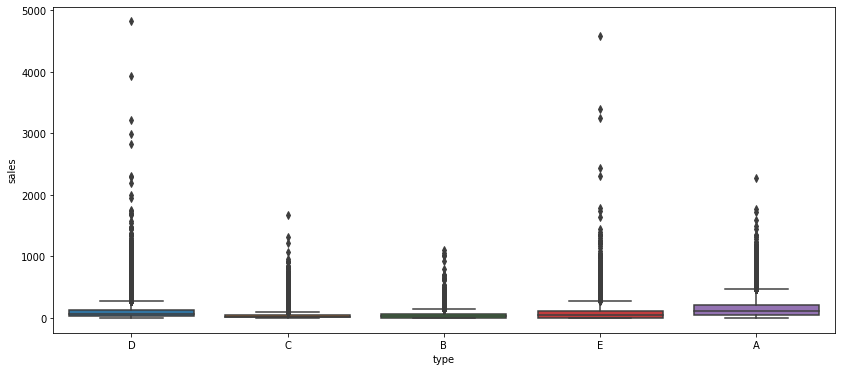

In [25]:
plt.figure(figsize=(14,6))
chart=sns.boxplot(x='type',y='sales',data=dfLiquor)

Se observa que existe una gran cantidad de outliers también en la distribución de acuerdo al tipo de tienda

(-20.0, 500.0)

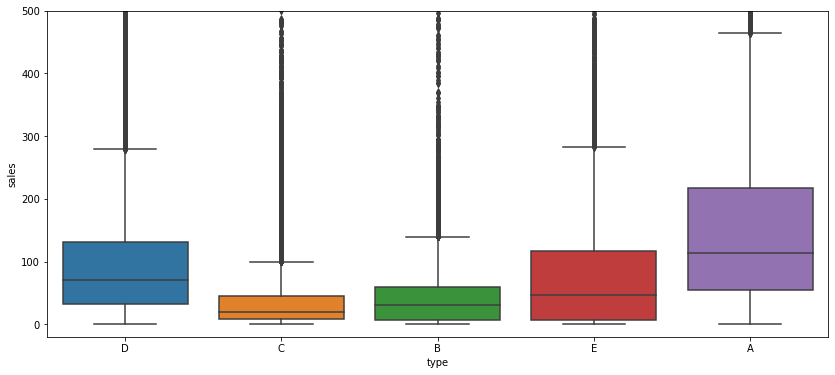

In [26]:
plt.figure(figsize=(14,6))
chart=sns.boxplot(x='type',y='sales',data=dfLiquor)
plt.ylim(-20,500)

Donde se vende la mayor cantidad de ventas en Licor es de las tiendas tipo A aunque tambien es el que posee mayor dispersión en el número de ventas, seguido de las tiendas tipo D y la tienda tipo C es la que posee las menores ventas en cuanto a licor.

### 2.2 Analizando fechas

In [27]:
pd.options.mode.chained_assignment = None  # default='warn'

In [28]:
dfLiquor['date']=pd.to_datetime(dfLiquor['date'])

dfLiquor['year']=dfLiquor['date'].dt.year
dfLiquor['month']=dfLiquor['date'].dt.month
dfLiquor['day']=dfLiquor['date'].dt.day
dfLiquor['week']=dfLiquor['date'].dt.isocalendar().week
dfLiquor['dayName']=dfLiquor['date'].dt.day_name()

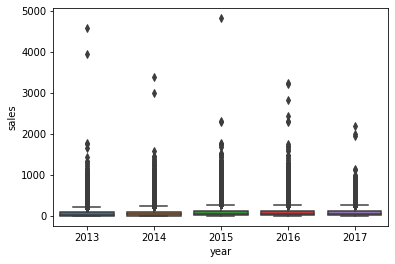

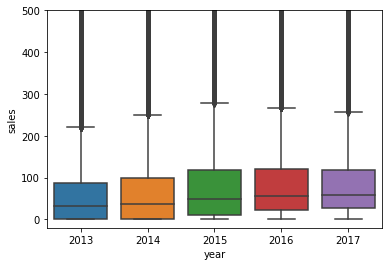

In [29]:
sns.boxplot(x='year',y='sales',data=dfLiquor)
plt.show()
plt.close()

sns.boxplot(x='year',y='sales',data=dfLiquor)
plt.ylim(-20,500)
plt.show()
plt.close()

Se observa que las ventas de licor desde 2013 hasta 2016 han venido aumentando, en 2017 la mediana de los precios es igual a la de 2016, de tal manera que en ese año se mantuvo constante las ventas.

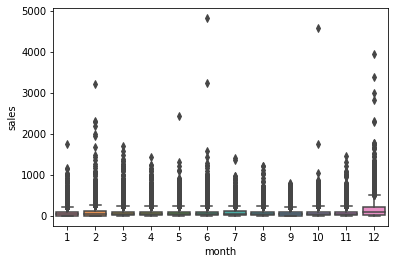

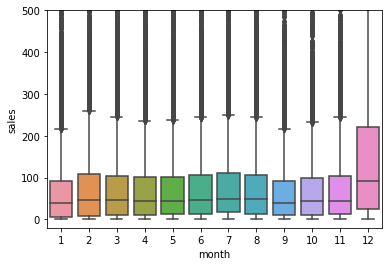

In [30]:
sns.boxplot(x='month',y='sales',data=dfLiquor)
plt.show()
plt.close()

sns.boxplot(x='month',y='sales',data=dfLiquor)
plt.ylim(-20,500)
plt.show()
plt.close()

Durante los meses, se observa que las ventas de licor son aproximadamente constantes, sin embargo, en el mes 12, es decir, dicimebre, aumentó en gran medida las ventas, esto es debido al aumento de consumo de licor en las festividades.

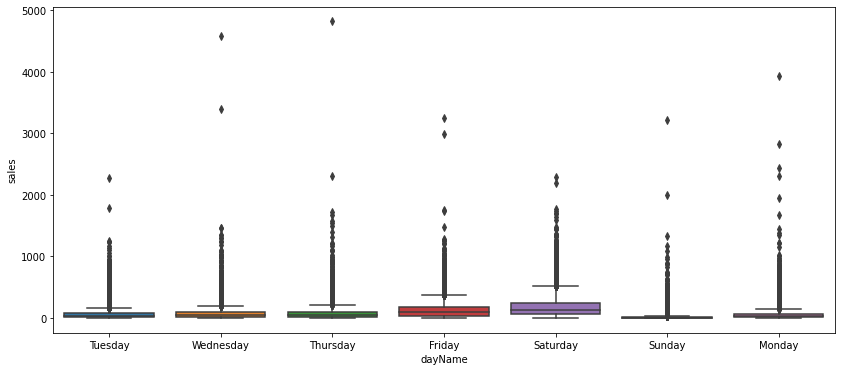

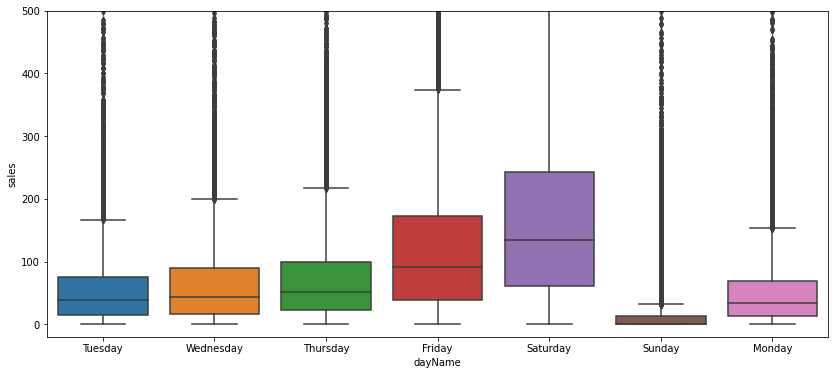

In [31]:
plt.figure(figsize=(14,6))
sns.boxplot(x='dayName',y='sales',data=dfLiquor)
plt.show()
plt.close()

plt.figure(figsize=(14,6))
sns.boxplot(x='dayName',y='sales',data=dfLiquor)
plt.ylim(-20,500)
plt.show()
plt.close()

Se observa que las vendas de licor se incrementan los días viernes y sábado, como era de esperarse, pues es el fin de semana. El domingo es el día donde menos se realiza compra de licor. 

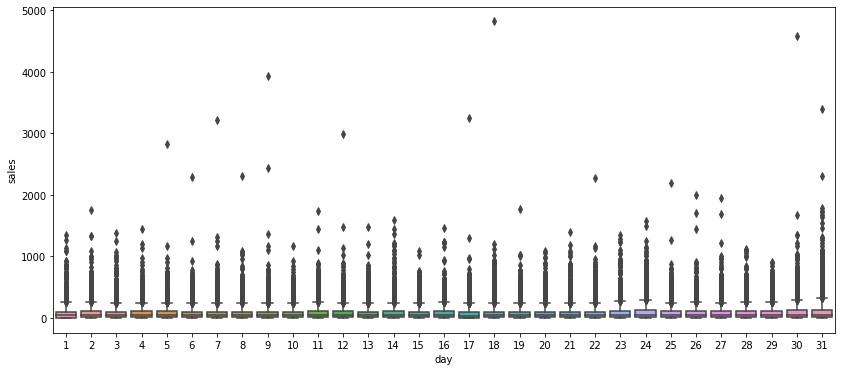

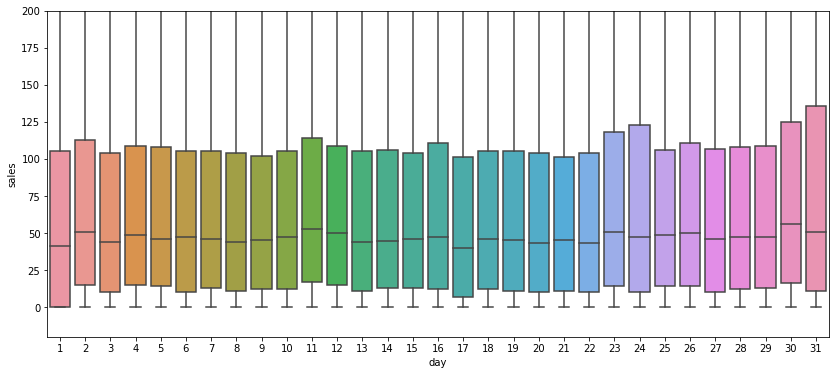

In [32]:
plt.figure(figsize=(14,6))
sns.boxplot(x='day',y='sales',data=dfLiquor)
plt.show()
plt.close()

plt.figure(figsize=(14,6))
sns.boxplot(x='day',y='sales',data=dfLiquor)
plt.ylim(-20,200)
plt.show()
plt.close()

Se observa que el día 30 es el día donde se realiza mayor cantidad de ventas, esto puede ser debido a que en los últimos días del mes es donde se realiza el pago de los salarios.

## 3. Series de tiempo

In [33]:
dfLiquor.tail()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,year,month,day,week,dayName
3000745,3000745,2017-08-15,54,"LIQUOR,WINE,BEER",210.0,2,El Carmen,Manabi,C,3,2017,8,15,33,Tuesday
3000778,3000778,2017-08-15,6,"LIQUOR,WINE,BEER",56.0,7,Quito,Pichincha,D,13,2017,8,15,33,Tuesday
3000811,3000811,2017-08-15,7,"LIQUOR,WINE,BEER",125.0,5,Quito,Pichincha,D,8,2017,8,15,33,Tuesday
3000844,3000844,2017-08-15,8,"LIQUOR,WINE,BEER",142.0,7,Quito,Pichincha,D,8,2017,8,15,33,Tuesday
3000877,3000877,2017-08-15,9,"LIQUOR,WINE,BEER",25.0,2,Quito,Pichincha,B,6,2017,8,15,33,Tuesday


In [34]:
dfLiquorDay=dfLiquor.groupby(['year','day'])['sales'].mean()

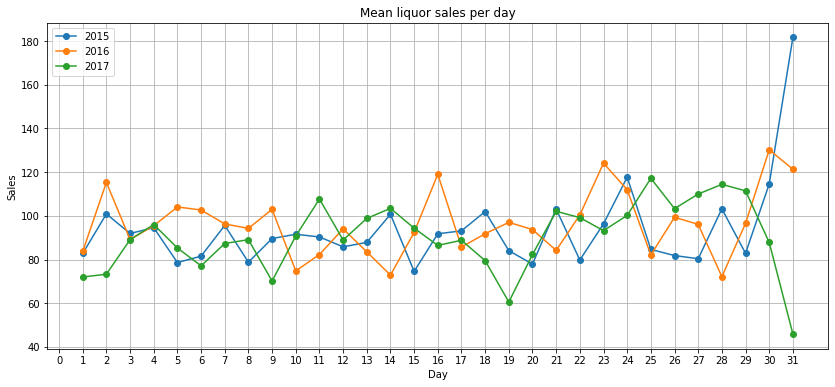

In [35]:
plt.figure(figsize=(14,6))
plt.grid()
plt.xlabel("Day")
plt.ylabel("Sales")
#plt.plot(dfLiquorDay[2013],label="2013")
#plt.plot(dfLiquorDay[2014],label="2014")
plt.plot(dfLiquorDay[2015],"o-", label="2015")
plt.plot(dfLiquorDay[2016],"o-", label="2016")
plt.plot(dfLiquorDay[2017],"o-", label="2017")

plt.legend()
plt.xticks(np.arange(0,32,1) );
plt.title("Mean liquor sales per day");

Se observa: 

- las ventas del licor posee cierto comportamiento oscilatorio.

- el 2016 fue el mejor año de ventas de licor.

- Las ventas tanto en 2015 como 2016 poseen valores altos al finalizar los meses, sin embargo, en 2017 hubo una caida preocupante, pues siempre se esperaba mayores ventas en estos días.



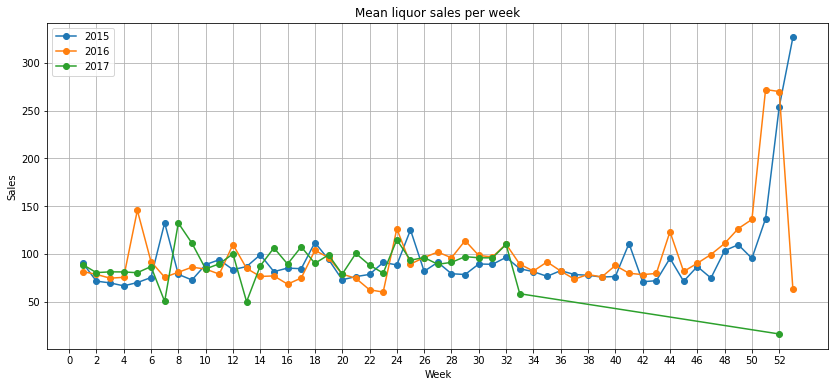

In [36]:
dfLiquorWeek=dfLiquor.groupby(['year','week'])['sales'].mean()

plt.figure(figsize=(14,6))
plt.grid()
plt.xlabel("Week")
plt.ylabel("Sales")
#plt.plot(dfLiquorDay[2013],label="2013")
#plt.plot(dfLiquorDay[2014],label="2014")
plt.plot(dfLiquorWeek[2015],"o-", label="2015")
plt.plot(dfLiquorWeek[2016],"o-", label="2016")
plt.plot(dfLiquorWeek[2017],"o-", label="2017")

plt.legend()
plt.xticks(np.arange(0,54,2) );
plt.title("Mean liquor sales per week");

Se observa que los datos de 2017 están imcompletos pues sólo presenta hasta la semana 32 y luego hay un salto a la semana 52, de tal manera que se debe de tener en cuenta esto a la hora de realizar predicciones

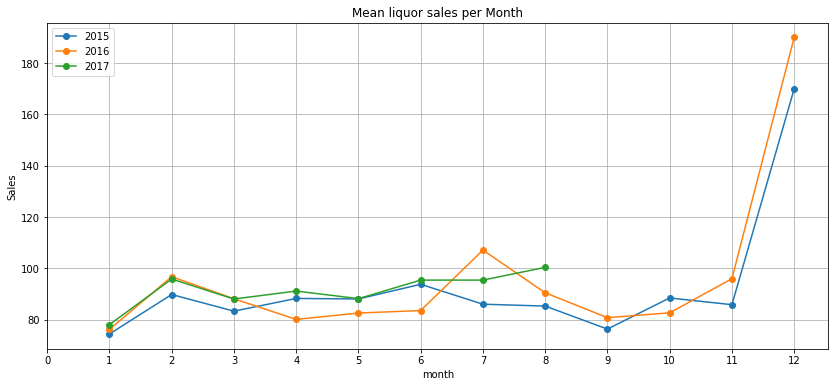

In [37]:
dfLiquorMonth=dfLiquor.groupby(['year','month'])['sales'].mean()

plt.figure(figsize=(14,6))
plt.grid()
plt.xlabel("month")
plt.ylabel("Sales")
#plt.plot(dfLiquorDay[2013],label="2013")
#plt.plot(dfLiquorDay[2014],label="2014")
plt.plot(dfLiquorMonth[2015],"o-", label="2015")
plt.plot(dfLiquorMonth[2016],"o-", label="2016")
plt.plot(dfLiquorMonth[2017],"o-", label="2017")

plt.legend()
plt.xticks(np.arange(0,13,1) );
plt.title("Mean liquor sales per Month");

Se vuelve a observa el pico de ventas en dicimebte sin importar el año.

Las bajas ventas en 2016 desde abril hasta junio pueden ser debido al terremoto que ocurrió en Ecuador el 16 de abril de ese año. si embargo, se envidencia que luego de esto las ventas incrementaron mucho más que los anteriores años. 

## 3.1 Preparando Dataset para la predicción de series de tiempo

In [38]:
dfLiquor.set_index('date', inplace=True)

In [138]:
dfLiquorAvg=(dfLiquor.groupby( [ dfLiquor.index.floor('7d') ] )['sales']
           .mean()
           .rename_axis('date')
          . reset_index(name='sales') )  #para que funcione se debe de haber cambiado primero date de string a datetime

In [139]:
dfLiquorAvg.head()

,date,sales
0,2012-12-27,23.296296
1,2013-01-03,53.219577
2,2013-01-10,56.558201
3,2013-01-17,55.428571
4,2013-01-24,55.219577


In [140]:
dfLiquorAvg.set_index('date', inplace=True)

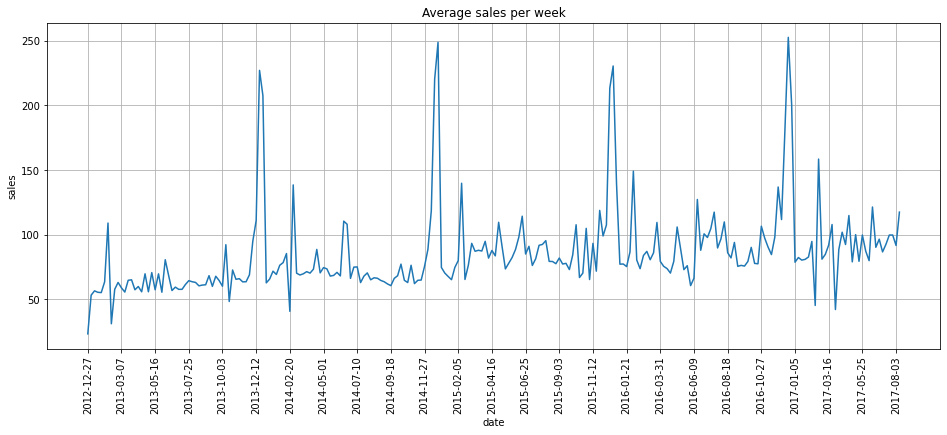

In [141]:
fig,ax=plt.subplots(figsize=(16,6))
plt.title("Average sales per week")
sns.lineplot(data=dfLiquorAvg,x=dfLiquorAvg.index, y='sales')
plt.grid()
plt.xticks( np.array(dfLiquorAvg.index)[::10] )
ax.tick_params(axis='x', rotation=90)




### Decomponiendo la serie de tiempo

In [43]:
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<Figure size 1152x432 with 0 Axes>

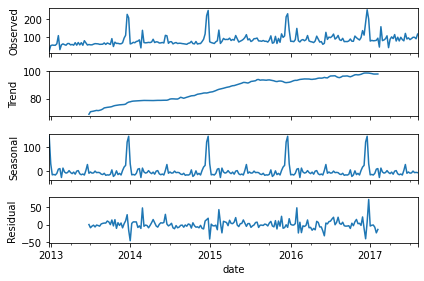

In [44]:
decompose=seasonal_decompose(dfLiquorAvg['sales'])
plt.figure(figsize=(16,6))
decompose.plot();

Se observa: 

Existe un comportamiento creciciente en la tendencia general, de tal manera que ha existido un aumento en las ventas, lo que es bueno para la empresa.

Existe un comportamiento estacionario pues cada julio y diciembre las ventas de licor suben, esto es debido a que se está en periodo vacacional.

## 4. Modelo de redes neuronales para la predicción de ventas 

### 4.1. Escalamiento de datos

In [45]:
from sklearn.preprocessing import MinMaxScaler

In [46]:
x_scaler=MinMaxScaler()
data=x_scaler.fit_transform( dfLiquorAvg['sales'].values.reshape(-1, 1)  )

### 4.2 Contruyendo el formato de datos para la predicción

In [47]:
def adecuacionDatos(df,numberInputs, numberOutputs):

  x=[]
  y=[]

  for i in range(numberInputs,len(df)-numberInputs):
    x.append( df[i-numberInputs:i] )
    y.append( df[i:i+numberOutputs][0] ) 

  return np.array(x), np.array(y)

Dividiendo los datos:


Se debe de tener especial ciudado en la separación de datos de train, validation y test pues deben de ser secuenciales

In [96]:
numberInputs=4
numberOutputs=1

X,y=adecuacionDatos(df=data,numberInputs=numberInputs, numberOutputs=numberOutputs)
len(X),len(y)

(234, 234)

In [97]:
porcentaje_train=0.8
porcentaje_val=0.1
porcentaje_test=0.2

train_size=int(len(X)*porcentaje_train*(1-porcentaje_val) )
validation_size=int(len(X)*porcentaje_train*(porcentaje_val) )
test_size=int(len(X)*porcentaje_test )

train_size,validation_size,test_size

(168, 18, 46)

In [115]:
x_train=X[0: train_size]
y_train=y[0: train_size]

x_validation=X[train_size:train_size+validation_size+1]
y_validation=y[train_size:train_size+validation_size+1]

x_test=X[train_size+validation_size+1:train_size+validation_size+test_size+1  ]
y_test=y[train_size+validation_size+1:train_size+validation_size+test_size+1 ]

In [116]:
x_train.shape, y_train.shape, x_validation.shape, y_validation.shape, x_test.shape , y_test.shape

((168, 4, 1), (168, 1), (19, 4, 1), (19, 1), (46, 4, 1), (46, 1))

### 4.3 Construcción del modelo

In [117]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer,Dense, LSTM
tf.random.set_seed(1234)

In [156]:
model=Sequential()
model.add( LSTM(units=50,activation="relu", 
                input_shape=(numberInputs,numberOutputs) )
         )
model.add(Dense(units=10))
model.add(Dense(units=1))

In [157]:
model.compile(optimizer='rmsprop',
             loss='mse',
              metrics=['mse'])

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 50)                10400     
                                                                 
 dense_19 (Dense)            (None, 10)                510       
                                                                 
 dense_20 (Dense)            (None, 1)                 11        
                                                                 
Total params: 10,921
Trainable params: 10,921
Non-trainable params: 0
_________________________________________________________________


In [158]:
history=model.fit(x_train, y_train, epochs=50, 
                  validation_data=(x_validation, y_validation), batch_size=32)

Epoch 1/50
6/6 [==============================] - 2s 54ms/step - loss: 0.0465 - mse: 0.0465 - val_loss: 0.0169 - val_mse: 0.0169
Epoch 2/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0214 - mse: 0.0214 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 3/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0190 - mse: 0.0190 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 4/50
6/6 [==============================] - 0s 8ms/step - loss: 0.0187 - mse: 0.0187 - val_loss: 0.0058 - val_mse: 0.0058
Epoch 5/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0192 - mse: 0.0192 - val_loss: 0.0058 - val_mse: 0.0058
Epoch 6/50
6/6 [==============================] - 0s 8ms/step - loss: 0.0182 - mse: 0.0182 - val_loss: 0.0080 - val_mse: 0.0080
Epoch 7/50
6/6 [==============================] - 0s 8ms/step - loss: 0.0185 - mse: 0.0185 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 8/50
6/6 [==============================] - 0s 8ms/step - loss: 0.0179 - mse: 0.0179 - val_loss: 

In [159]:
def plot_metrics(history):

    plt.figure(figsize=(12,6))
    plt.plot(history.history['val_mse'], label="validation")
    plt.plot(history.history['mse'], label="training")
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()

2/2 [==============================] - 0s 10ms/step - loss: 0.0203 - mse: 0.0203


[0.020262282341718674, 0.020262282341718674]

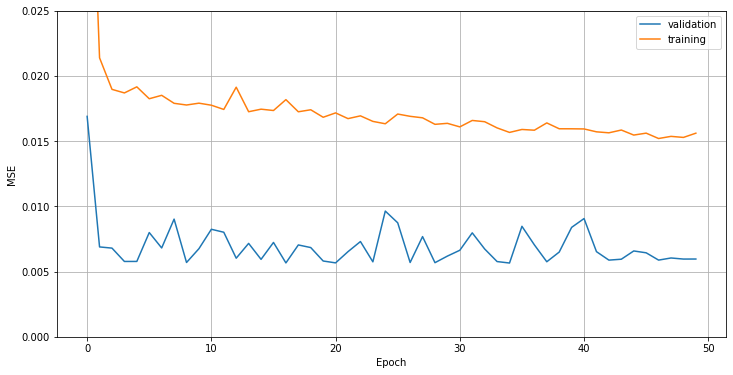

In [160]:
plot_metrics(history)
plt.ylim(0,0.025)

model.evaluate(x_test,y_test)

Se observa que el modelo se desempeña de mejor manera en los datos de validación, esto puede deberse a que simplemente los datos escogidos para la validación son más "fáciles" que los datos de entrenamiento. Se observa que las oscilaciones son bastante grandes, de tal manera que se disminuirá el learning rate en las subsiguientes secciones.



In [122]:
#y_predicted_scaled=model.predict(x_train)
#y_predicted=x_scaler.inverse_transform(y_predicted_scaled)
#y_test=x_scaler.inverse_transform(y_train)

def re_escalamiento(x,y,x_scaler):
  y_predicted_scaled=model.predict(x)
  y_predicted=x_scaler.inverse_transform(y_predicted_scaled)
  y_true=x_scaler.inverse_transform(y)

  return y_predicted, y_true


y_predicted_train, y_true_train=re_escalamiento(x_train,y_train,x_scaler)
y_predicted_validation, y_true_validation=re_escalamiento(x_validation,y_validation,x_scaler)
y_predicted_test, y_true_test=re_escalamiento(x_test,y_test,x_scaler)


In [124]:
index_train=np.arange(0, train_size)
index_validation=np.arange(train_size,train_size+validation_size+1)
index_test=np.arange(train_size+validation_size+1,train_size+validation_size+test_size+1  )

Text(0, 0.5, 'average price')

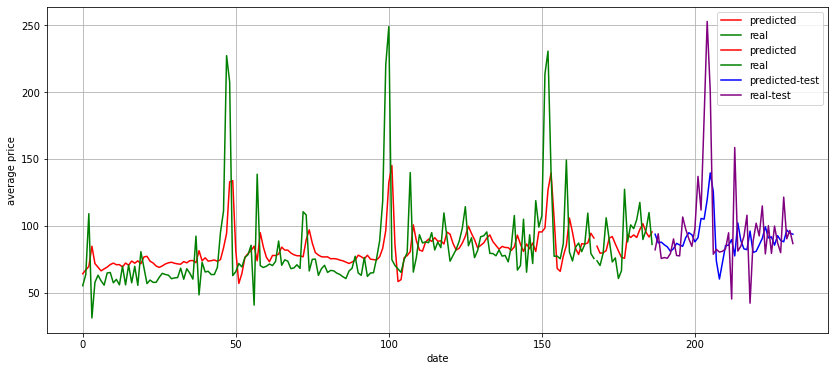

In [129]:
plt.figure(figsize=(14,6))
plt.plot(index_train,y_predicted_train, label="predicted", color="red")
plt.plot(index_train,y_true_train, label="real", color="green")

plt.plot(index_validation,y_predicted_validation, label="predicted" , color="red")
plt.plot(index_validation, y_true_validation, label="real", color="green")

plt.plot(index_test,y_predicted_test, label="predicted-test" , color="blue")
plt.plot(index_test,y_true_test, label="real-test" , color="purple")


plt.legend()
plt.grid()
plt.xlabel("date")
plt.ylabel("average price")

### 5. Variando hiperparámetros del modelo

In [144]:
from tensorflow.keras.optimizers import RMSprop

### 5.1 Variando learning rate

In [165]:
def get_model_learning_rate(input_shape):
  model=Sequential()
  model.add( LSTM(units=50,activation="relu", 
                  input_shape=input_shape )
          )
  model.add(Dense(units=10))
  model.add(Dense(units=1))
      
  return model

def compile_model_learning_rate(model, learning_rate):
    model.compile(optimizer=RMSprop(learning_rate=learning_rate), loss="mse", metrics="mse")

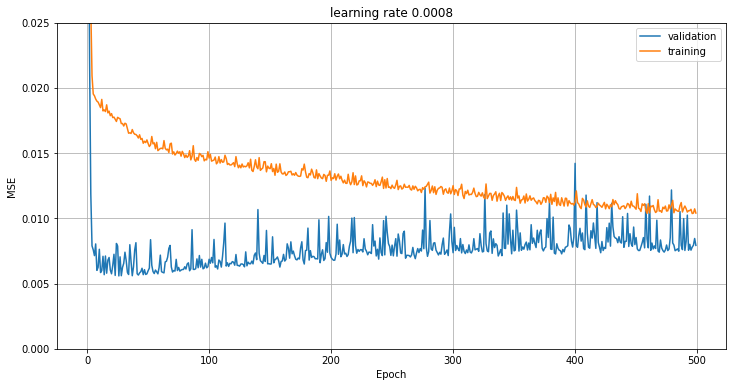

Eevaluacion en test con learning_rate=0.0008
2/2 [==============================] - 0s 6ms/step - loss: 0.0154 - mse: 0.0154






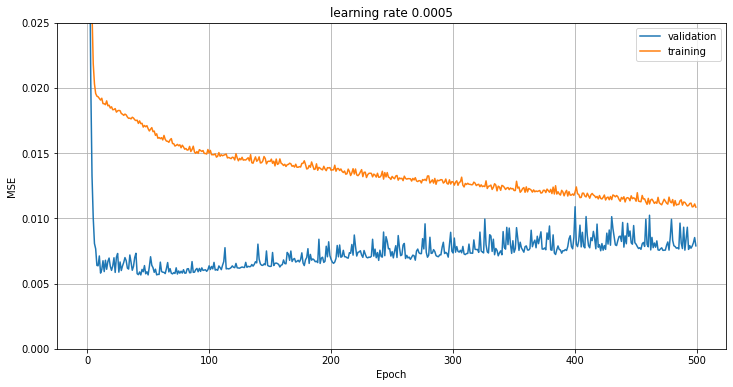

Eevaluacion en test con learning_rate=0.0005
2/2 [==============================] - 0s 5ms/step - loss: 0.0172 - mse: 0.0172






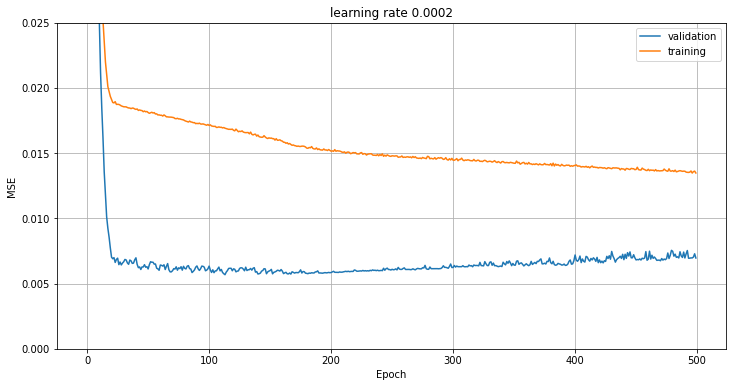

Eevaluacion en test con learning_rate=0.0002
2/2 [==============================] - 0s 8ms/step - loss: 0.0199 - mse: 0.0199






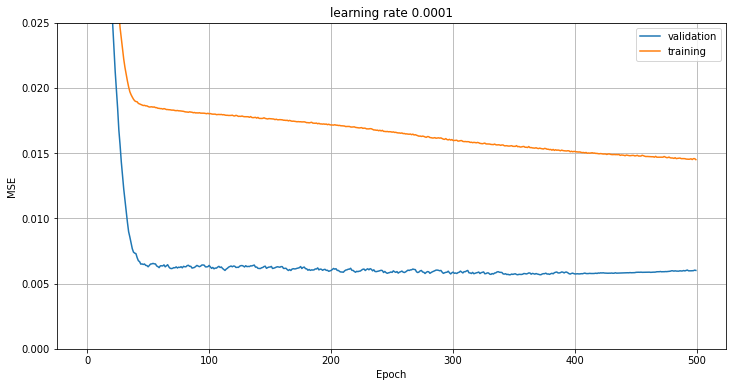

Eevaluacion en test con learning_rate=0.0001
2/2 [==============================] - 0s 8ms/step - loss: 0.0203 - mse: 0.0203






In [169]:
learning_rate=[0.0008,0.0005,0.0002,0.0001]

for alpha in learning_rate:
  model=get_model_learning_rate((numberInputs,numberOutputs) )
  compile_model_learning_rate(model, learning_rate=alpha)
  history=model.fit(x_train, y_train, epochs=500, 
                    validation_data=(x_validation, y_validation), batch_size=32, verbose=0)
  

  plot_metrics(history)
  plt.title(f"learning rate {alpha}")
  plt.ylim(0,0.025)
  plt.show()
  plt.close()
  print(f"Eevaluacion en test con learning_rate={alpha}")
  model.evaluate(x_test,y_test)
  print("\n")
  print("\n")

Se observa que un learning rate más bajo realiza mejores predicciones

### 5.2 Variando optimizador de la red neuronal
---



In [180]:
def get_model_optimizer(input_shape):
  model=Sequential()
  model.add( LSTM(units=50,activation="relu", 
                  input_shape=input_shape )
          )
  model.add(Dense(units=10))
  model.add(Dense(units=1))
      
  return model

def compile_model_optimizer(model, optimizer):
    model.compile(optimizer=optimizer(learning_rate=0.0001), loss="mse", metrics="mse")

In [172]:
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Adagrad

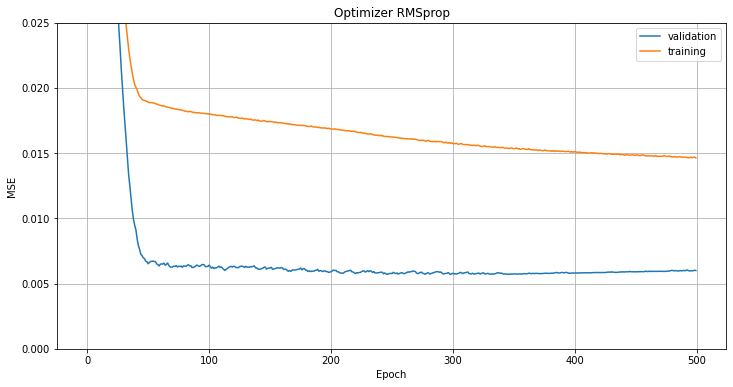

Optimizer:RMSprop
2/2 [==============================] - 0s 4ms/step - loss: 0.0200 - mse: 0.0200






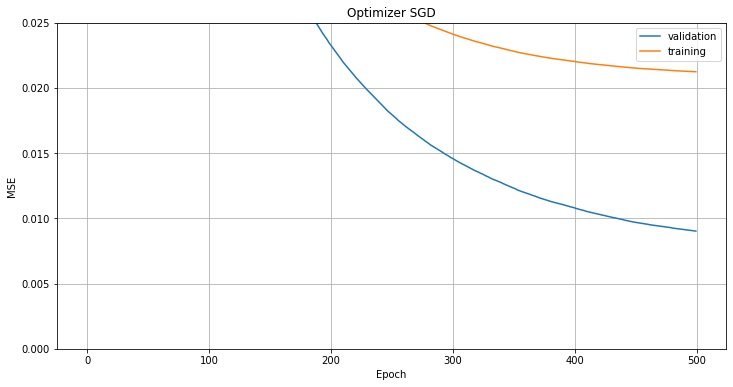

Optimizer:SGD
2/2 [==============================] - 0s 6ms/step - loss: 0.0339 - mse: 0.0339






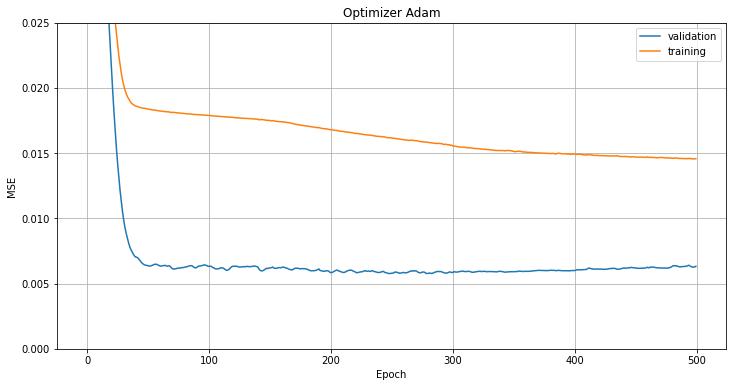

Optimizer:Adam
2/2 [==============================] - 0s 5ms/step - loss: 0.0203 - mse: 0.0203






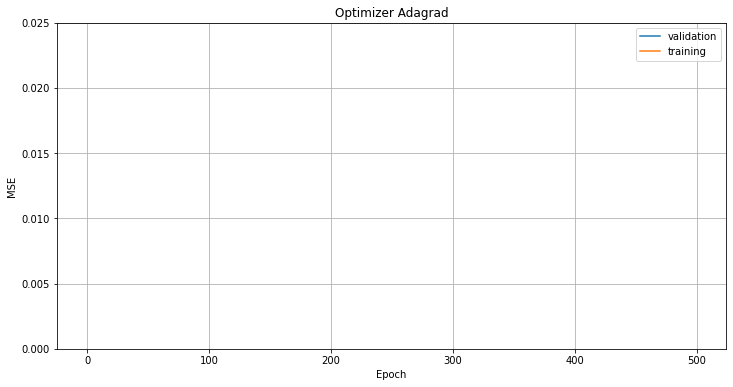

Optimizer:Adagrad
2/2 [==============================] - 0s 8ms/step - loss: 0.0676 - mse: 0.0676






In [182]:
optimizers=[RMSprop, SGD, Adam, Adagrad]
optimizerNames=['RMSprop', 'SGD', 'Adam', 'Adagrad' ]

for optimizer, optimizerName in zip(optimizers, optimizerNames):
  model=get_model_optimizer((numberInputs,numberOutputs) )
  compile_model_optimizer(model, optimizer=optimizer)
  history=model.fit(x_train, y_train, epochs=500, validation_data=(x_validation, y_validation), batch_size=32, verbose=0)
  
  plot_metrics(history)
  plt.title(f"Optimizer {optimizerName}")
  plt.ylim(0,0.025)
  plt.show()
  plt.close()
  print(f"Optimizer:{optimizerName}")
  model.evaluate(x_test,y_test)
  print("\n")
  print("\n")

Se obtiene que el mejor optimizador es RMSprop

## 5.3 Variando función de activación 

In [193]:
def get_model_activation(input_shape, activation):
  model=Sequential()
  model.add( LSTM(units=50,activation=activation, 
                  input_shape=input_shape )
          )
  model.add(Dense(units=10, activation=activation))
  model.add(Dense(units=1))   
  return model

def compile_model_activation(model):
    model.compile(optimizer=RMSprop(learning_rate=0.0001), loss="mse", metrics="mse")

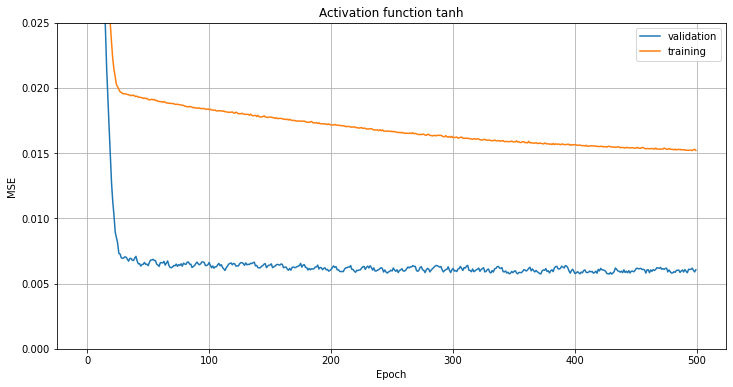

Activation function:tanh
2/2 [==============================] - 0s 5ms/step - loss: 0.0211 - mse: 0.0211






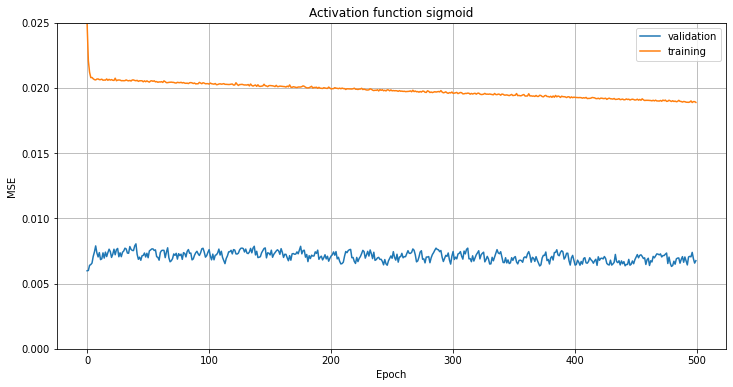

Activation function:sigmoid
2/2 [==============================] - 0s 6ms/step - loss: 0.0272 - mse: 0.0272






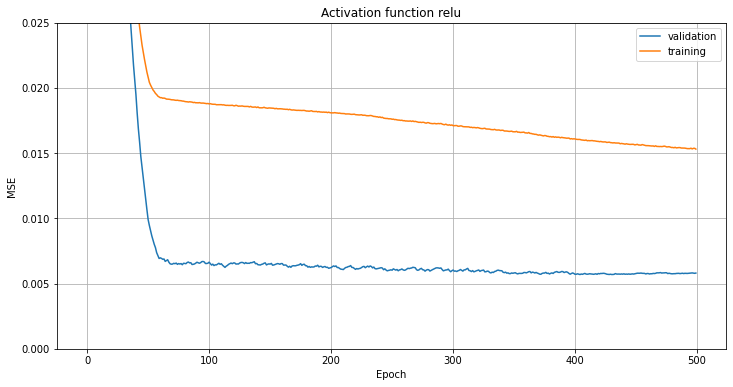

Activation function:relu
2/2 [==============================] - 0s 5ms/step - loss: 0.0209 - mse: 0.0209






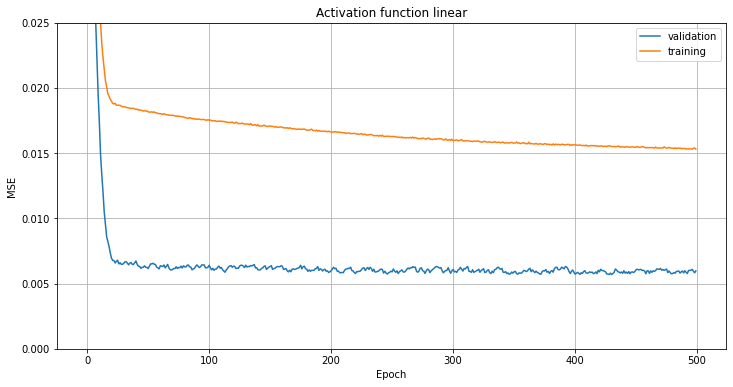

Activation function:linear
2/2 [==============================] - 0s 6ms/step - loss: 0.0211 - mse: 0.0211






In [197]:

activationFunctions=['tanh', 'sigmoid', 'relu', 'linear' ]

for activation in activationFunctions:
  model=get_model_activation( (numberInputs,numberOutputs) , activation=activation )
  compile_model_activation(model)
  history=model.fit(x_train, y_train, epochs=500, validation_data=(x_validation, y_validation), batch_size=32, verbose=0)
  
  plot_metrics(history)
  plt.title(f"Activation function {activation}")
  plt.ylim(0,0.025)
  plt.show()
  plt.close()
  print(f"Activation function:{activation}")
  model.evaluate(x_test,y_test)
  print("\n")
  print("\n")

Se observa que la función de activación ReLu es la que da mejor resultado

### 5.4 Variando el número de neuronas

In [199]:
def get_model_numberN(input_shape, units_LSTM, units_dense ):
  model=Sequential()
  model.add( LSTM(units=units_LSTM,activation='relu', 
                  input_shape=input_shape )
          )
  model.add(Dense(units=units_dense, activation='relu'))
  model.add(Dense(units=1))   
  return model

def compile_model_numberN(model):
    model.compile(optimizer=RMSprop(learning_rate=0.0001), loss="mse", metrics="mse")

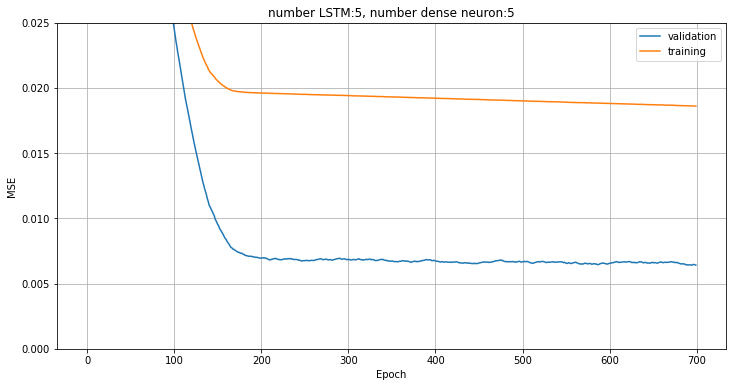

number LSTM:5, number dense neuron:5
2/2 [==============================] - 0s 6ms/step - loss: 0.0255 - mse: 0.0255






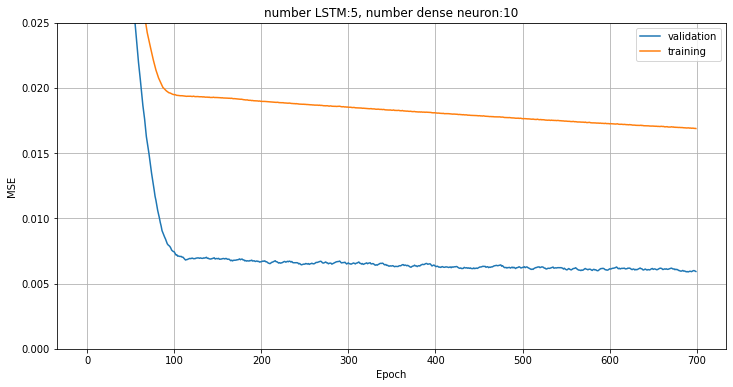

number LSTM:5, number dense neuron:10
2/2 [==============================] - 0s 7ms/step - loss: 0.0225 - mse: 0.0225






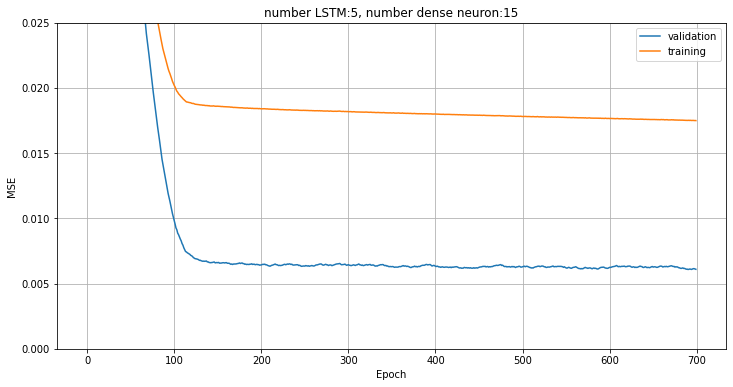

number LSTM:5, number dense neuron:15
2/2 [==============================] - 0s 8ms/step - loss: 0.0234 - mse: 0.0234






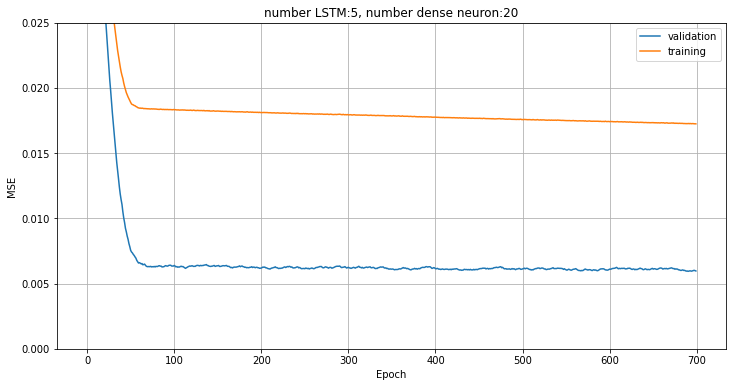

number LSTM:5, number dense neuron:20
2/2 [==============================] - 0s 4ms/step - loss: 0.0229 - mse: 0.0229






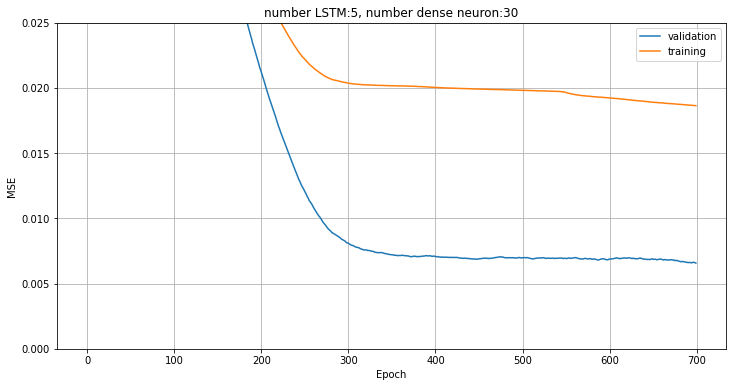

number LSTM:5, number dense neuron:30
2/2 [==============================] - 0s 5ms/step - loss: 0.0267 - mse: 0.0267






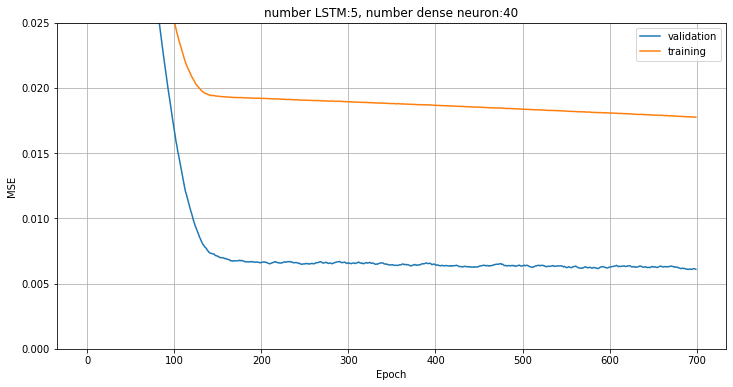

number LSTM:5, number dense neuron:40
2/2 [==============================] - 0s 6ms/step - loss: 0.0242 - mse: 0.0242






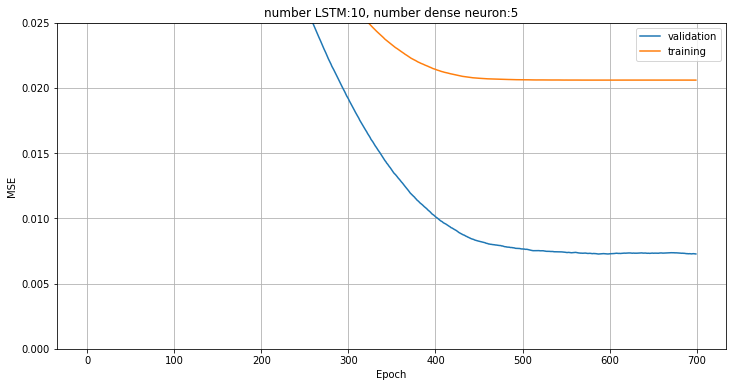

number LSTM:10, number dense neuron:5
2/2 [==============================] - 0s 6ms/step - loss: 0.0300 - mse: 0.0300






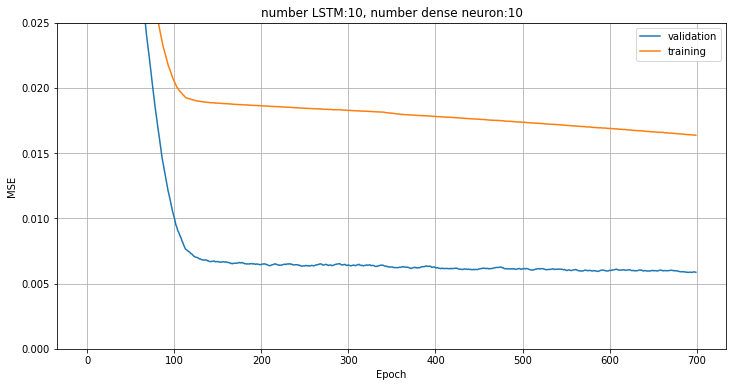

number LSTM:10, number dense neuron:10
2/2 [==============================] - 0s 5ms/step - loss: 0.0218 - mse: 0.0218






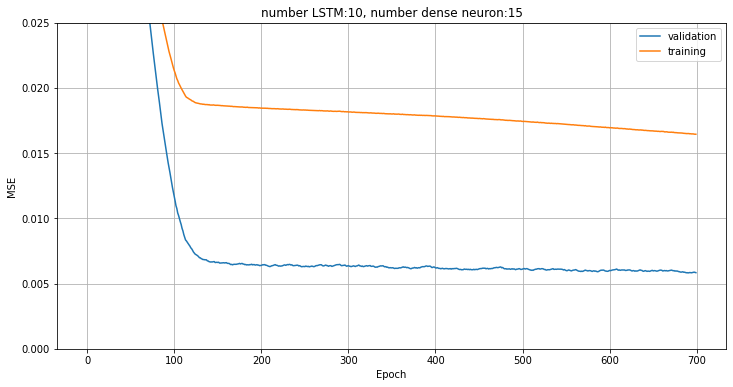

number LSTM:10, number dense neuron:15
2/2 [==============================] - 0s 5ms/step - loss: 0.0217 - mse: 0.0217






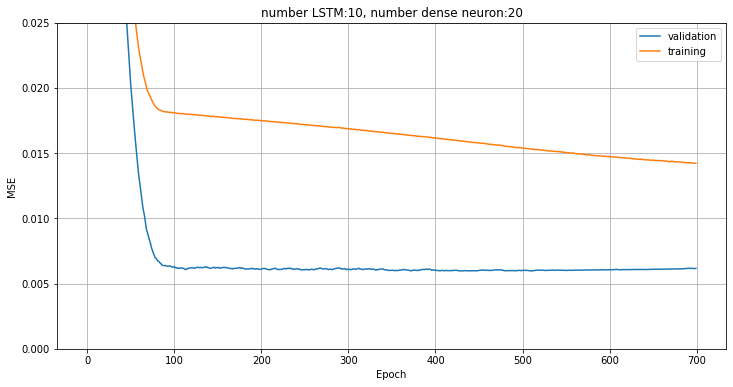

number LSTM:10, number dense neuron:20
2/2 [==============================] - 0s 10ms/step - loss: 0.0196 - mse: 0.0196






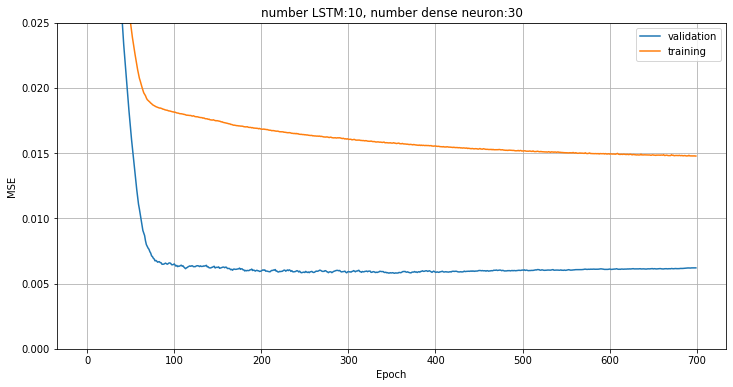

number LSTM:10, number dense neuron:30
2/2 [==============================] - 0s 8ms/step - loss: 0.0205 - mse: 0.0205






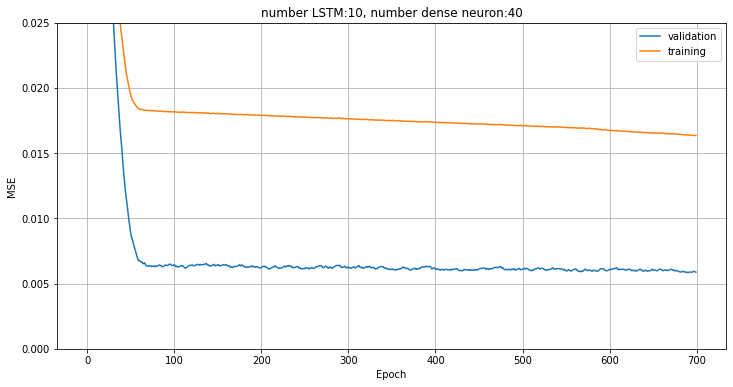

number LSTM:10, number dense neuron:40
2/2 [==============================] - 0s 5ms/step - loss: 0.0216 - mse: 0.0216






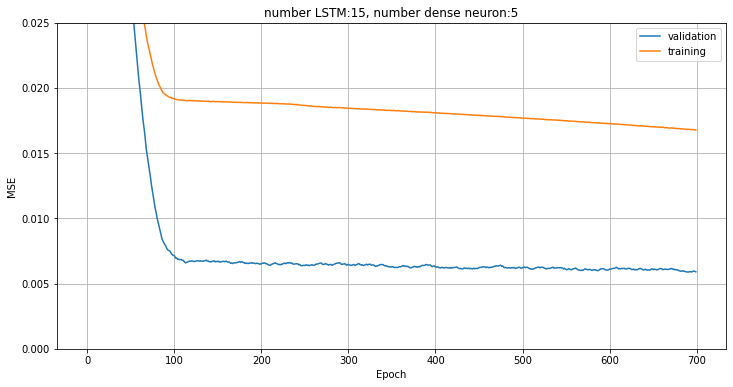

number LSTM:15, number dense neuron:5
2/2 [==============================] - 0s 5ms/step - loss: 0.0224 - mse: 0.0224






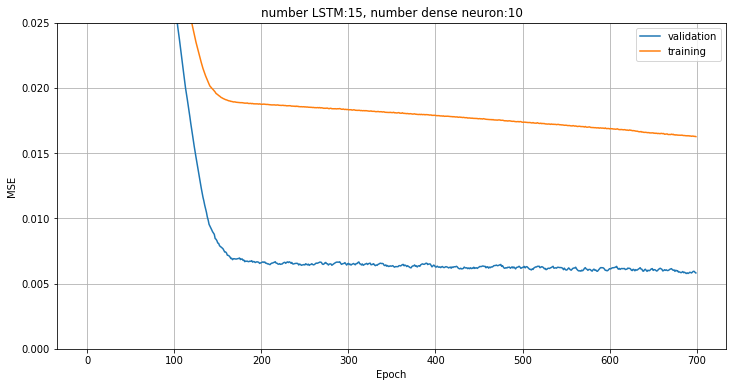

number LSTM:15, number dense neuron:10
2/2 [==============================] - 0s 7ms/step - loss: 0.0219 - mse: 0.0219






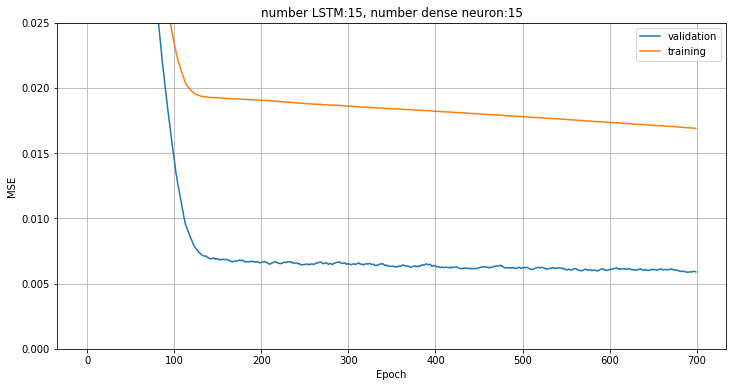

number LSTM:15, number dense neuron:15
2/2 [==============================] - 0s 10ms/step - loss: 0.0225 - mse: 0.0225






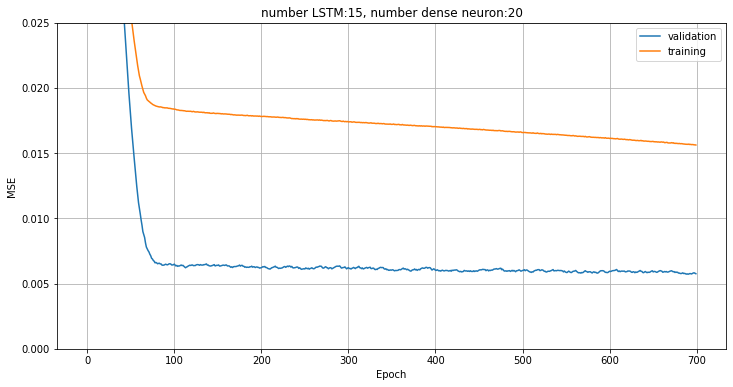

number LSTM:15, number dense neuron:20
2/2 [==============================] - 0s 5ms/step - loss: 0.0211 - mse: 0.0211






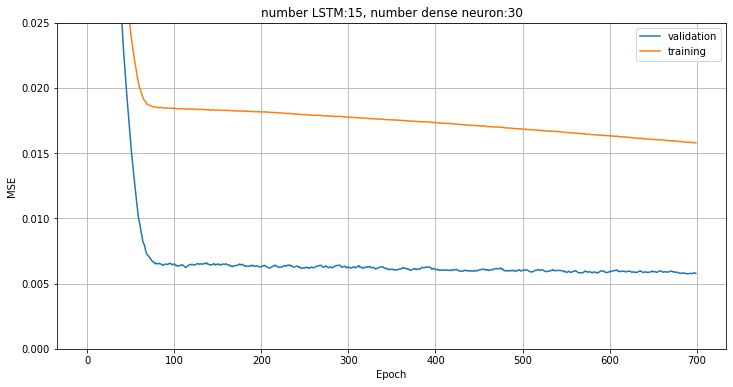

number LSTM:15, number dense neuron:30
2/2 [==============================] - 0s 7ms/step - loss: 0.0209 - mse: 0.0209






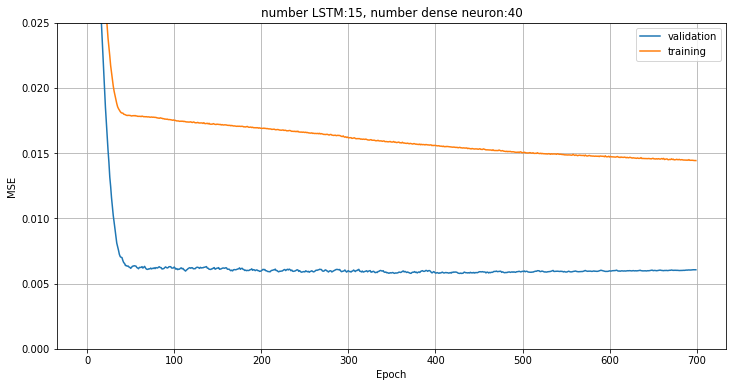

number LSTM:15, number dense neuron:40
2/2 [==============================] - 0s 4ms/step - loss: 0.0199 - mse: 0.0199






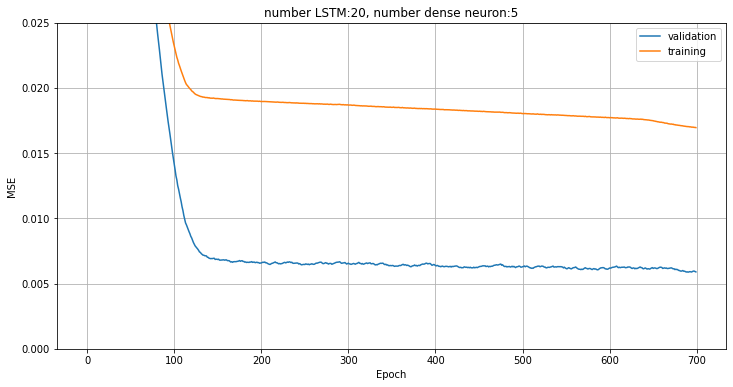

number LSTM:20, number dense neuron:5
2/2 [==============================] - 0s 7ms/step - loss: 0.0226 - mse: 0.0226






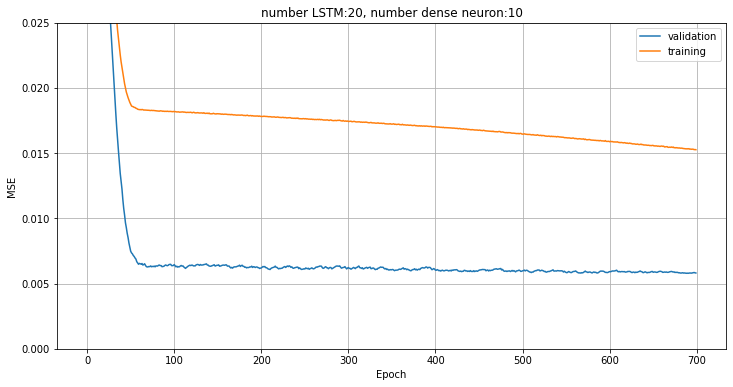

number LSTM:20, number dense neuron:10
2/2 [==============================] - 0s 5ms/step - loss: 0.0209 - mse: 0.0209






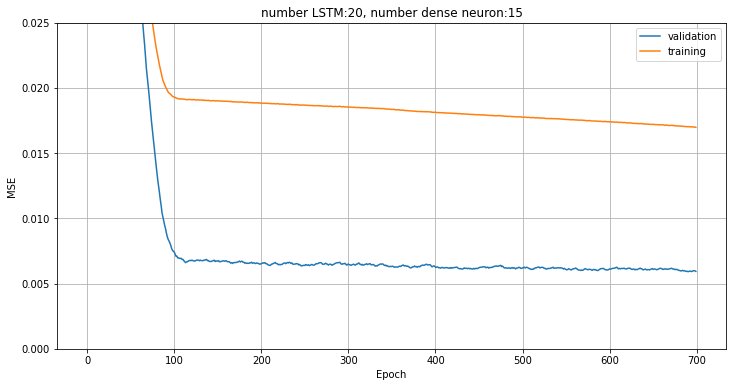

number LSTM:20, number dense neuron:15
2/2 [==============================] - 0s 4ms/step - loss: 0.0225 - mse: 0.0225






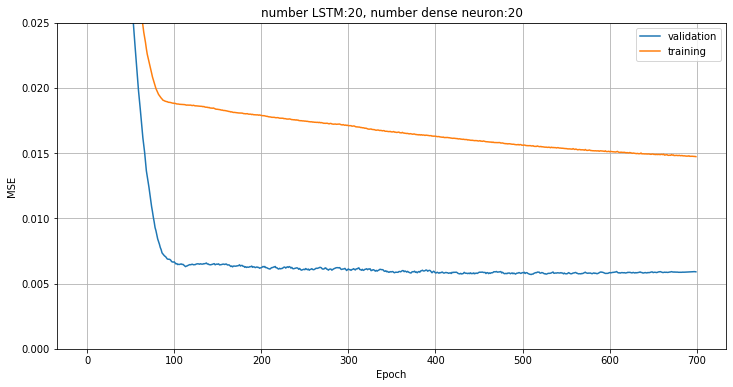

number LSTM:20, number dense neuron:20
2/2 [==============================] - 0s 5ms/step - loss: 0.0201 - mse: 0.0201






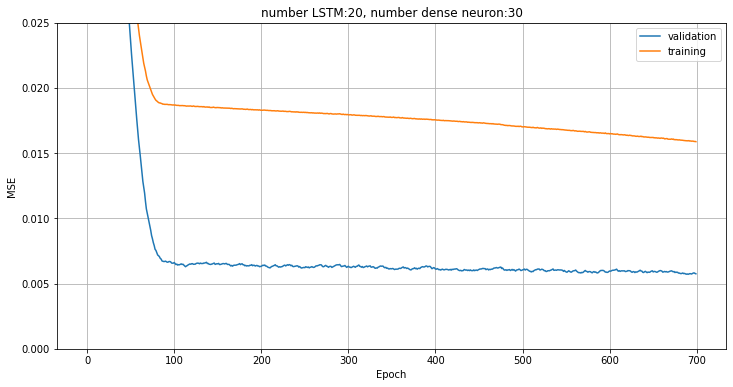

number LSTM:20, number dense neuron:30
2/2 [==============================] - 0s 7ms/step - loss: 0.0214 - mse: 0.0214






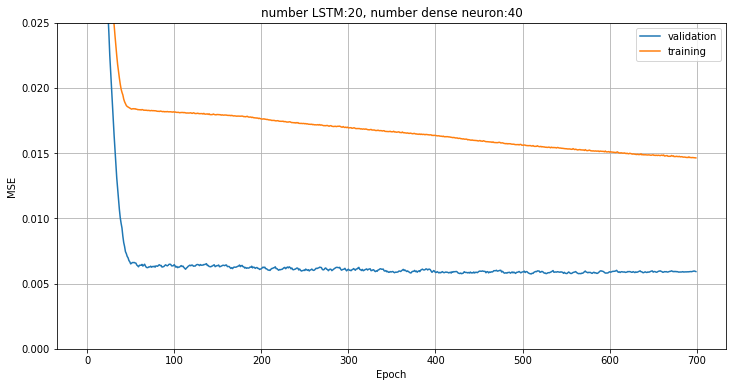

number LSTM:20, number dense neuron:40
2/2 [==============================] - 0s 5ms/step - loss: 0.0204 - mse: 0.0204






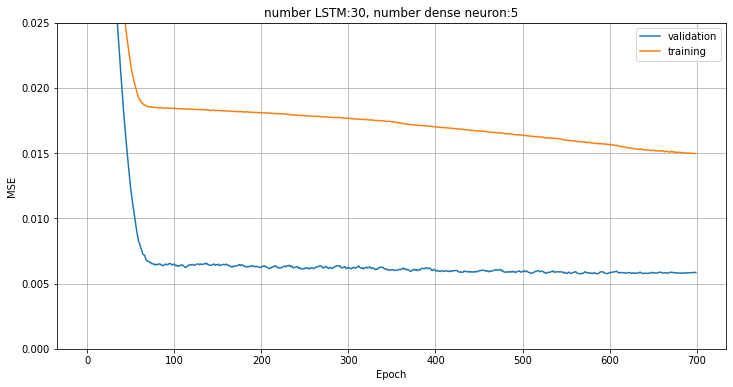

number LSTM:30, number dense neuron:5
2/2 [==============================] - 0s 5ms/step - loss: 0.0203 - mse: 0.0203






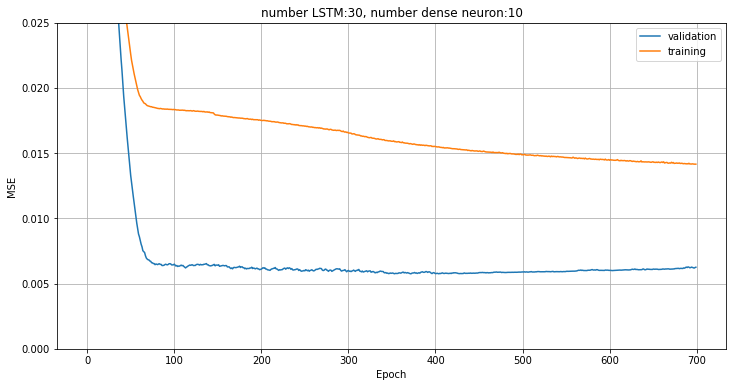

number LSTM:30, number dense neuron:10
2/2 [==============================] - 0s 5ms/step - loss: 0.0201 - mse: 0.0201






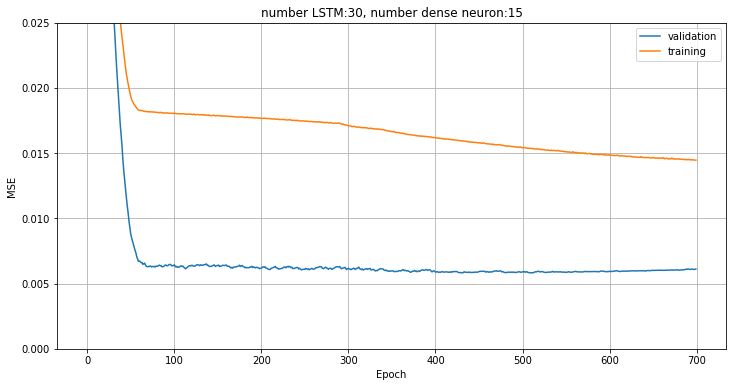

number LSTM:30, number dense neuron:15
2/2 [==============================] - 0s 9ms/step - loss: 0.0199 - mse: 0.0199






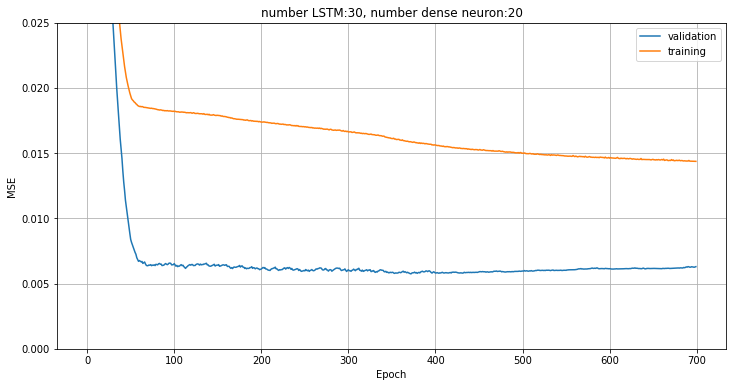

number LSTM:30, number dense neuron:20
2/2 [==============================] - 0s 5ms/step - loss: 0.0201 - mse: 0.0201






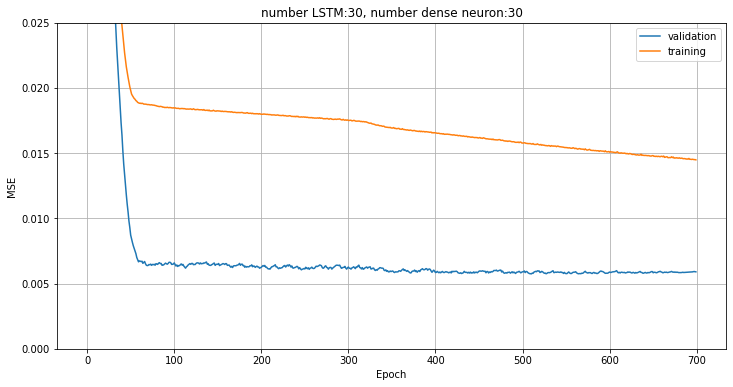

number LSTM:30, number dense neuron:30
2/2 [==============================] - 0s 6ms/step - loss: 0.0202 - mse: 0.0202






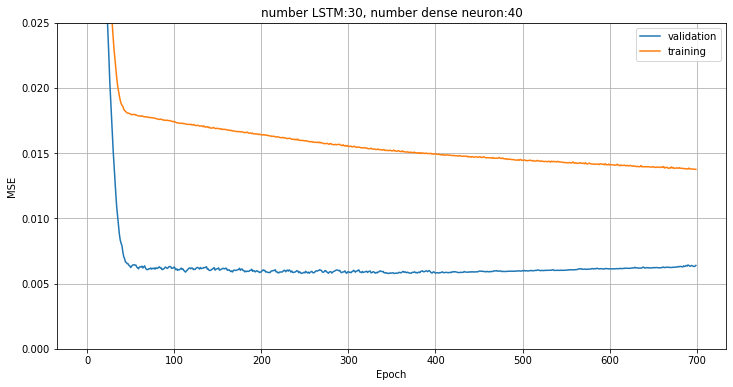

number LSTM:30, number dense neuron:40
2/2 [==============================] - 0s 7ms/step - loss: 0.0193 - mse: 0.0193






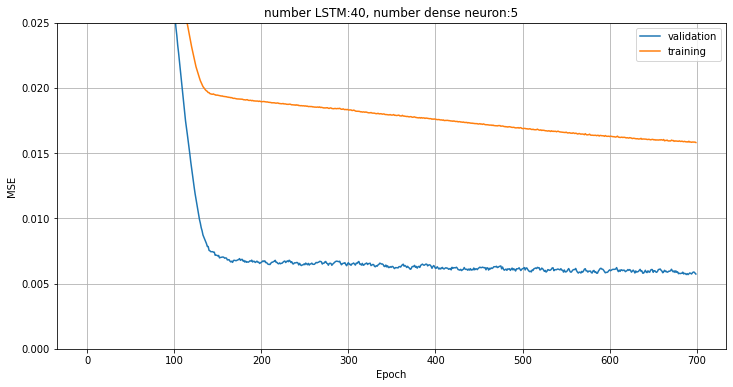

number LSTM:40, number dense neuron:5
2/2 [==============================] - 0s 4ms/step - loss: 0.0208 - mse: 0.0208






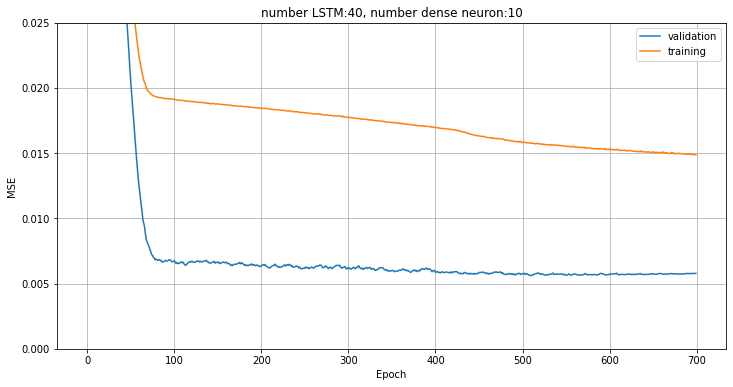

number LSTM:40, number dense neuron:10
2/2 [==============================] - 0s 4ms/step - loss: 0.0200 - mse: 0.0200






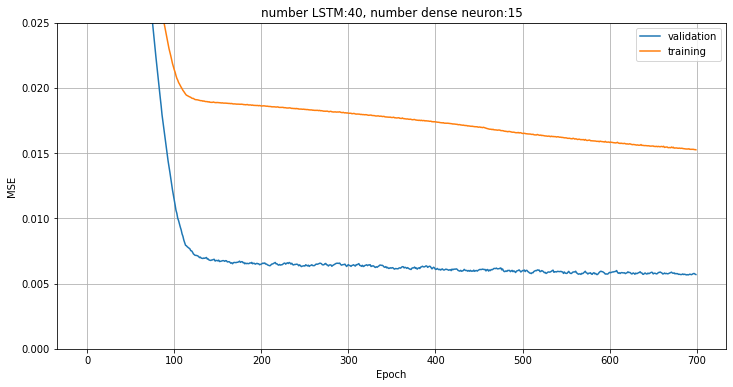

number LSTM:40, number dense neuron:15
2/2 [==============================] - 0s 8ms/step - loss: 0.0206 - mse: 0.0206






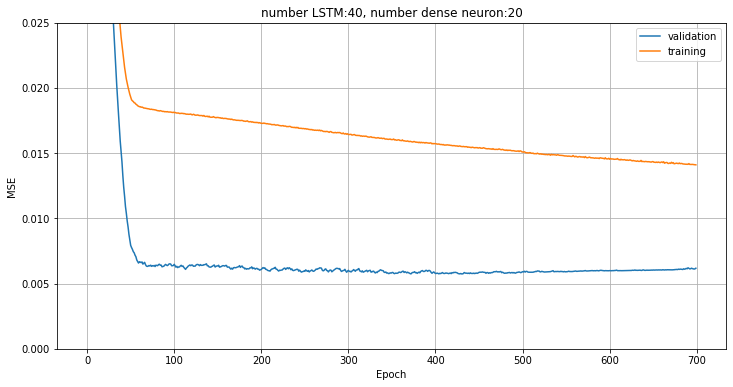

number LSTM:40, number dense neuron:20
2/2 [==============================] - 0s 6ms/step - loss: 0.0192 - mse: 0.0192






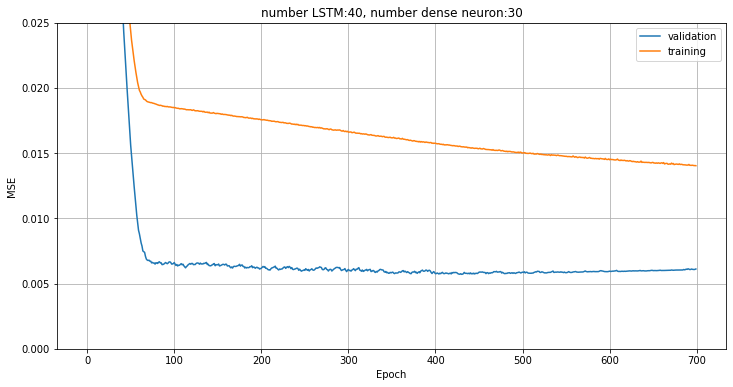

number LSTM:40, number dense neuron:30
2/2 [==============================] - 0s 5ms/step - loss: 0.0191 - mse: 0.0191






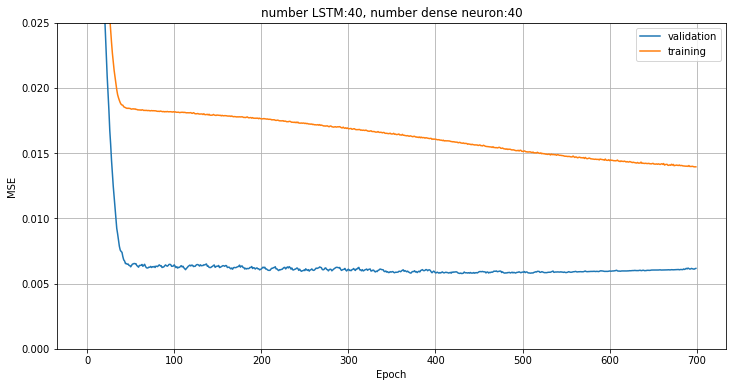

number LSTM:40, number dense neuron:40
2/2 [==============================] - 0s 7ms/step - loss: 0.0194 - mse: 0.0194






In [201]:
LSTM_neurons=[5,10,15,20,30,40]
dense_neurons=[5,10,15,20,30,40]

for LSTM_neuron in LSTM_neurons:
  for dense_neuron in dense_neurons:

    model=get_model_numberN( (numberInputs,numberOutputs) , units_LSTM=LSTM_neuron, units_dense=dense_neuron)
    compile_model_numberN(model)
    history=model.fit(x_train, y_train, epochs=700, validation_data=(x_validation, y_validation), batch_size=32, verbose=0)
    
    plot_metrics(history)
    plt.title(f"number LSTM:{LSTM_neuron}, number dense neuron:{dense_neuron}")
    plt.ylim(0,0.025)
    plt.show()
    plt.close()
    print(f"number LSTM:{LSTM_neuron}, number dense neuron:{dense_neuron}")
    model.evaluate(x_test,y_test)
    print("\n")
    print("\n")

Se encuentra que el mejor modelo en los datos de testeo es el que posee 40 neuronas en LSTM y 30 neuronas en la capa densa pues posee un MSE de 0.0191 

### 5.5 Número óptimo de fechas de entrenamiento para la predicción 

In [202]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

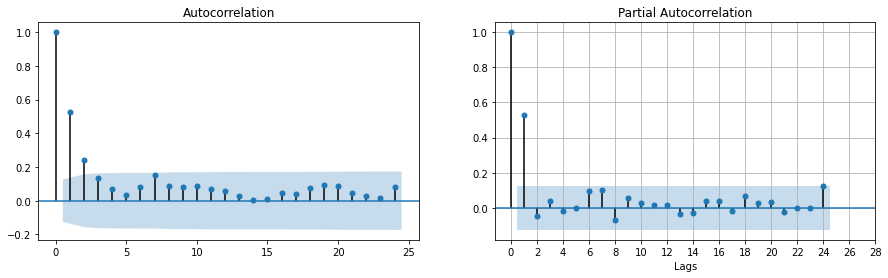

In [203]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,4))
res1 = plot_acf(dfLiquorAvg['sales'],ax=ax[0])
plt.xlabel('Lags')
plt.xticks(np.arange(0,30,2))
plt.grid()

res2 = plot_pacf(dfLiquorAvg['sales'], ax=ax[1])
plt.xlabel('Lags')
plt.xticks(np.arange(0,30,2))
plt.show()
plt.close()

Según las gráficas de autocorrelación, el número más correcto para realizar las predicciones de las ventas de la semana es usar las ventas promedio de una sola semana anterior

In [206]:
def get_model(input_shape):
  model=Sequential()
  model.add( LSTM(units=40,activation='relu', 
                  input_shape=input_shape )
          )
  model.add(Dense(units=30, activation='relu'))
  model.add(Dense(units=1))   
  return model

def compile_model(model):
    model.compile(optimizer=RMSprop(learning_rate=0.0001), loss="mse", metrics="mse")

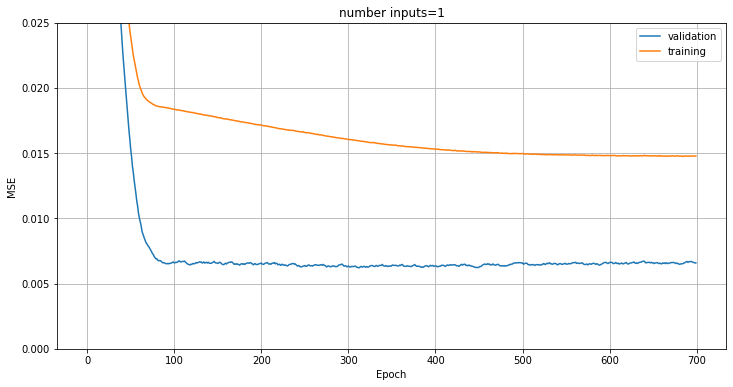

number inputs=1
2/2 [==============================] - 0s 6ms/step - loss: 0.0212 - mse: 0.0212






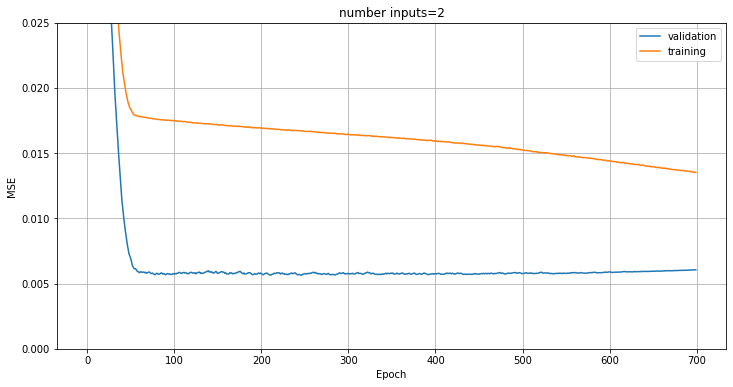

number inputs=2
2/2 [==============================] - 0s 5ms/step - loss: 0.0194 - mse: 0.0194






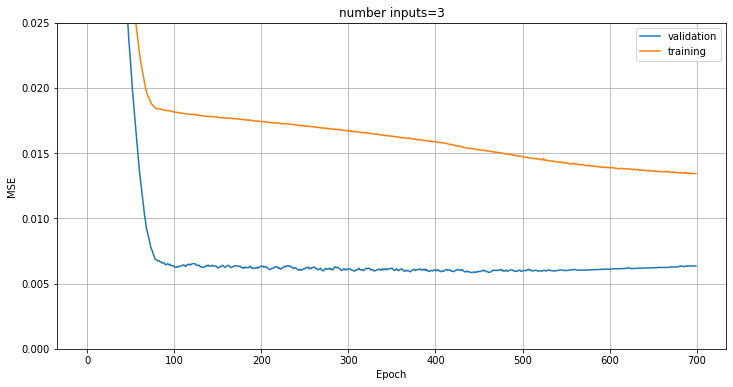

number inputs=3
2/2 [==============================] - 0s 8ms/step - loss: 0.0184 - mse: 0.0184






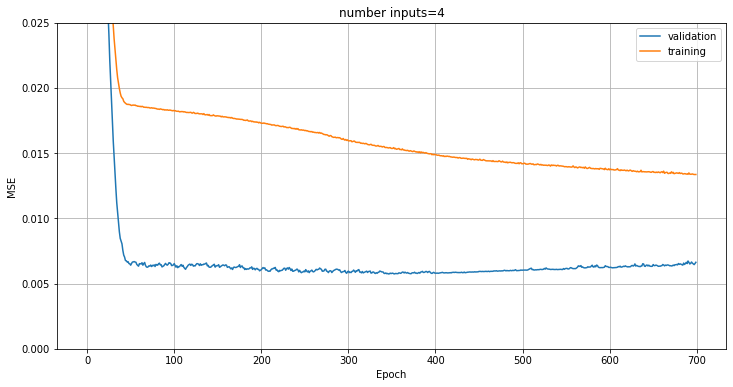

number inputs=4
2/2 [==============================] - 0s 6ms/step - loss: 0.0193 - mse: 0.0193






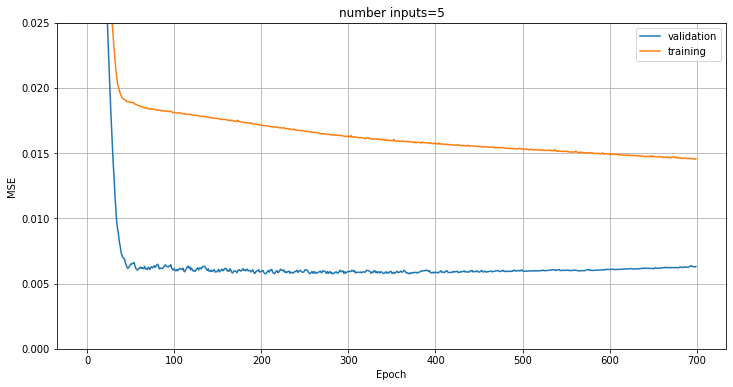

number inputs=5
2/2 [==============================] - 0s 9ms/step - loss: 0.0202 - mse: 0.0202






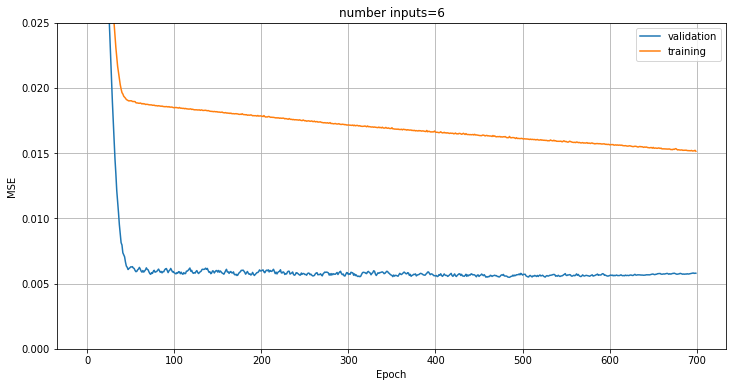

number inputs=6
2/2 [==============================] - 0s 8ms/step - loss: 0.0211 - mse: 0.0211






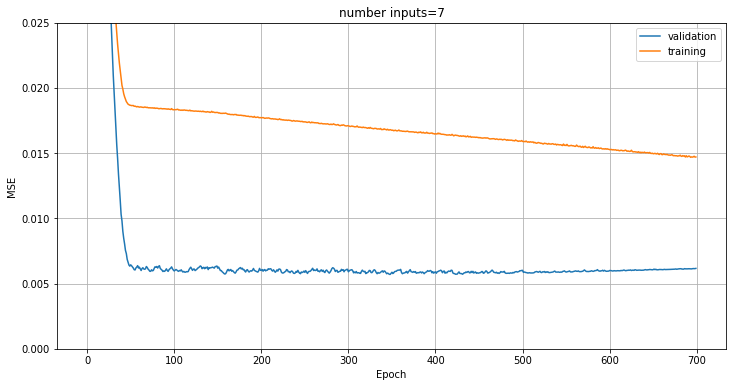

number inputs=7
2/2 [==============================] - 0s 11ms/step - loss: 0.0228 - mse: 0.0228






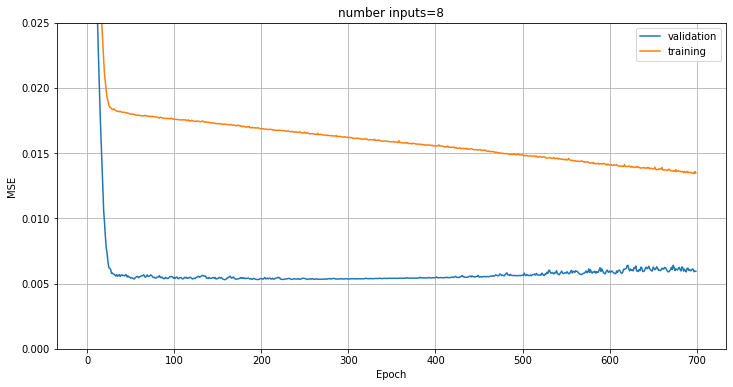

number inputs=8
2/2 [==============================] - 0s 11ms/step - loss: 0.0228 - mse: 0.0228






In [212]:
number_inputs=[1,2,3,4,5,6,7,8]  

for number_input in number_inputs:
  numberOutputs=1

  X,y=adecuacionDatos(df=data,numberInputs=number_input, numberOutputs=numberOutputs)

  x_train=X[0: train_size]
  y_train=y[0: train_size]

  x_validation=X[train_size:train_size+validation_size+1]
  y_validation=y[train_size:train_size+validation_size+1]

  x_test=X[train_size+validation_size+1:train_size+validation_size+test_size+1 ]
  y_test=y[train_size+validation_size+1:train_size+validation_size+test_size+1 ]


  model=get_model( (number_input,numberOutputs) )
  compile_model(model)
  history=model.fit(x_train, y_train, epochs=700, validation_data=(x_validation, y_validation), batch_size=32, verbose=0)
      
  plot_metrics(history)
  plt.title(f"number inputs={number_input}")
  plt.ylim(0,0.025)
  plt.show()
  plt.close()

  print(f"number inputs={number_input}")
  model.evaluate(x_test,y_test)
  print("\n")
  print("\n")

Se encuentra que el mejor resultado en los datos de test sucede cuando se entrena la red con tres semanas antes, de tal manera que se usará este número

### 5.6 Probando otras arquitecturas

#### 5.6.1 Dos LSTM

In [218]:
  X,y=adecuacionDatos(df=data,numberInputs=3, numberOutputs=1)

  x_train=X[0: train_size]
  y_train=y[0: train_size]

  x_validation=X[train_size:train_size+validation_size+1]
  y_validation=y[train_size:train_size+validation_size+1]

  x_test=X[train_size+validation_size+1:train_size+validation_size+test_size+1 ]
  y_test=y[train_size+validation_size+1:train_size+validation_size+test_size+1 ]

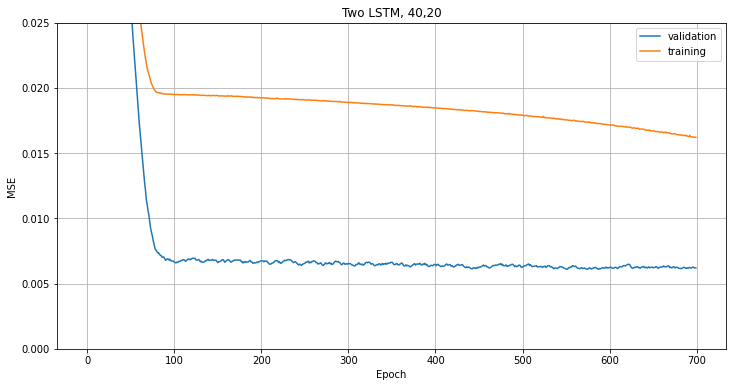

Two LSTM, 40,20
2/2 [==============================] - 0s 8ms/step - loss: 0.0214 - mse: 0.0214


[0.021366501227021217, 0.021366501227021217]

In [219]:
model=Sequential()
model.add(LSTM(40,activation='relu', return_sequences=True, input_shape=(3,1)) )
model.add(LSTM(20, activation='relu') )
model.add(Dense(10,activation='relu') )
model.add(Dense(1))

model.compile(optimizer=RMSprop(learning_rate=0.0001), loss="mse", metrics="mse")

history=model.fit(x_train, y_train, epochs=700, validation_data=(x_validation, y_validation), batch_size=32, verbose=0)
   
plot_metrics(history)
plt.title(f"Two LSTM, 40,20")
plt.ylim(0,0.025)
plt.show()
plt.close()

print(f"Two LSTM, 40,20")
model.evaluate(x_test,y_test)


No se observa una mejora respecto al modelo anterior pues que el desempeño en los datos de test es de 0.0214

#### 5.6.2 Convolutional LSTM

In [220]:
from tensorflow.keras.layers import ConvLSTM2D

5.6.3 Bidirection LSTM

In [221]:
from keras.layers import Bidirectional

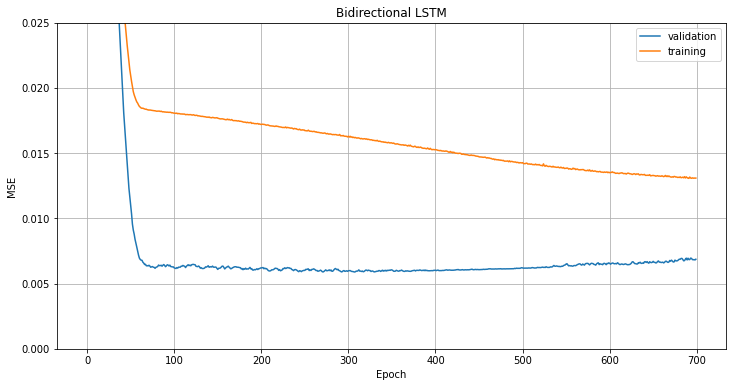

Bidirectional LSTM
2/2 [==============================] - 0s 7ms/step - loss: 0.0186 - mse: 0.0186


[0.018636099994182587, 0.018636099994182587]

In [224]:
model=Sequential()
model.add( Bidirectional(LSTM(40,activation='relu'), input_shape=(3,1)  ) ) 
model.add(Dense(30,activation='relu') )
model.add(Dense(1))

model.compile(optimizer=RMSprop(learning_rate=0.0001), loss="mse", metrics="mse")

history=model.fit(x_train, y_train, epochs=700, validation_data=(x_validation, y_validation), batch_size=32, verbose=0)
   
plot_metrics(history)
plt.title(f"Bidirectional LSTM")
plt.ylim(0,0.025)
plt.show()
plt.close()

print(f"Bidirectional LSTM")
model.evaluate(x_test,y_test)



## 6. Realizando predicciones con el mejor modelo y guardando pesos.

De tal manera que el mejor modelo para la predicción es una RNN LSTM de 40 capas, unido con una capa densa de 30 neuronas, con optimizador RMSprop con learning rate de 0.0001, funciones de activación ReLu y alimentada con los datos de las tres semanas anteriores

In [232]:
import h5py
from tensorflow.keras.callbacks import ModelCheckpoint

In [233]:
path = "/content/drive/MyDrive/Proyecto redes neuronales/"
checkpoint_path = path + 'my_NN_model2.h5'

In [234]:
def get_model(input_shape):
  model=Sequential()
  model.add( LSTM(units=40,activation='relu', 
                  input_shape=input_shape )
          )
  model.add(Dense(units=30, activation='relu'))
  model.add(Dense(units=1))   
  return model

def compile_model(model):
    model.compile(optimizer=RMSprop(learning_rate=0.0001), loss="mse", metrics="mse")


Epoch 1: saving model to /content/drive/MyDrive/Proyecto redes neuronales/my_NN_model2.h5

Epoch 2: saving model to /content/drive/MyDrive/Proyecto redes neuronales/my_NN_model2.h5

Epoch 3: saving model to /content/drive/MyDrive/Proyecto redes neuronales/my_NN_model2.h5

Epoch 4: saving model to /content/drive/MyDrive/Proyecto redes neuronales/my_NN_model2.h5

Epoch 5: saving model to /content/drive/MyDrive/Proyecto redes neuronales/my_NN_model2.h5

Epoch 6: saving model to /content/drive/MyDrive/Proyecto redes neuronales/my_NN_model2.h5

Epoch 7: saving model to /content/drive/MyDrive/Proyecto redes neuronales/my_NN_model2.h5

Epoch 8: saving model to /content/drive/MyDrive/Proyecto redes neuronales/my_NN_model2.h5

Epoch 9: saving model to /content/drive/MyDrive/Proyecto redes neuronales/my_NN_model2.h5

Epoch 10: saving model to /content/drive/MyDrive/Proyecto redes neuronales/my_NN_model2.h5

Epoch 11: saving model to /content/drive/MyDrive/Proyecto redes neuronales/my_NN_model2.

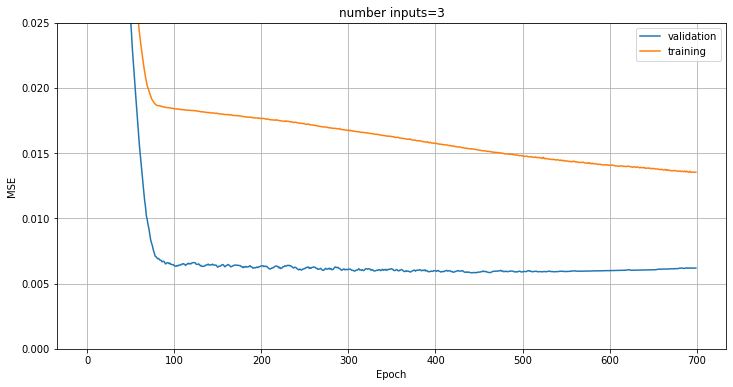

number inputs=8
2/2 [==============================] - 0s 6ms/step - loss: 0.0183 - mse: 0.0183






In [236]:
  model=get_model( (3,1) )
  compile_model(model)
  history=model.fit(x_train, y_train, epochs=700, 
                    validation_data=(x_validation, y_validation),
                    batch_size=32, verbose=0,
                    callbacks=[ModelCheckpoint(filepath=checkpoint_path,frequency='epoch',
                                                           verbose=1) ] )
      
  plot_metrics(history)
  plt.title(f"number inputs=3")
  plt.ylim(0,0.025)
  plt.show()
  plt.close()

  print(f"number inputs={number_input}")
  model.evaluate(x_test,y_test)
  print("\n")
  print("\n")

Text(0, 0.5, 'average price')

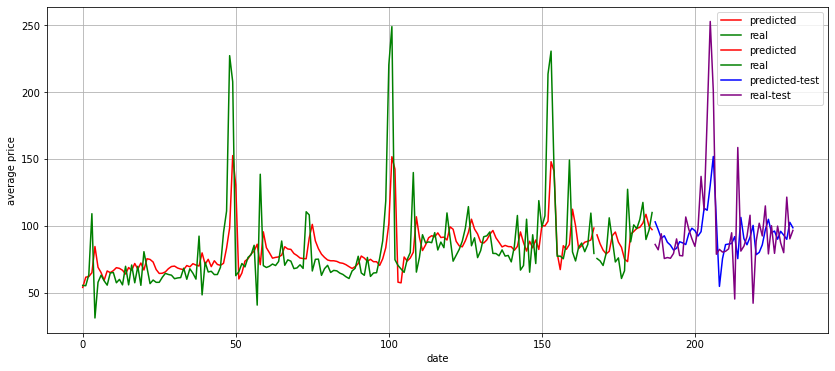

In [231]:
y_predicted_train, y_true_train=re_escalamiento(x_train,y_train,x_scaler)
y_predicted_validation, y_true_validation=re_escalamiento(x_validation,y_validation,x_scaler)
y_predicted_test, y_true_test=re_escalamiento(x_test,y_test,x_scaler)

index_train=np.arange(0, train_size)
index_validation=np.arange(train_size,train_size+validation_size+1)
index_test=np.arange(train_size+validation_size+1,train_size+validation_size+test_size+1  )



plt.figure(figsize=(14,6))
plt.plot(index_train,y_predicted_train, label="predicted", color="red")
plt.plot(index_train,y_true_train, label="real", color="green")

plt.plot(index_validation,y_predicted_validation, label="predicted" , color="red")
plt.plot(index_validation, y_true_validation, label="real", color="green")

plt.plot(index_test,y_predicted_test, label="predicted-test" , color="blue")
plt.plot(index_test,y_true_test, label="real-test" , color="purple")


plt.legend()
plt.grid()
plt.xlabel("date")
plt.ylabel("Average sales")

Se observa que se está reproduciendo de buena manera los datos de test, esto también lo demuestra el valor de 0.0183 en MSE obtenido. 

Se desea tener más poder computacional para seguir explorando el espacio de hiperparámetros y conseguir aún mejores predicciones.